<a id='start'></a>

# Εργασία Εξόρυξης Γνώσης από Δεδομένα, ΕΔΕΜΜ

<a id='sec0'></a>

## 0. Εισαγωγή

Στόχο της παρούσας εργασίας αποτελεί η φόρτωση, η προεπεξεργασία και η διερευνητική ανάλυση δεδομένων παγκόσμιας κλίμακας που αφορούν την πανδημία του SARS-Cov-2. Το [σύνολο δεδομένων](https://github.com/owid/covid-19-data/blob/master/public/data/README.md) δημιουργήθηκε και συντηρείται από την [Our World in Data](https://ourworldindata.org/coronavirus) και η χρονική περίοδος που μελετάται στην εργασία αυτή είναι οι μήνες Ιανουάριος & Φεβρουάριος 2021. Όλα τα ζητούμενα παρατίθενται στο παρόν notebook υπό τη μορφή quotes (`>`) και υλοποιούνται αυστηρά μέσω [PySpark](https://spark.apache.org/docs/latest/api/python/). Για εκπαιδευτικούς λόγους, βιβλιοθήκες όπως η Pandas δεν μπορούν να αξιοποιηθούν, παρά μόνο για αισθητικούς λόγους (π.χ. απεικόνιση ενός μικρού resultnet το οποίο αποτελεί το τελικό προϊόν κάποιων PySpark queries).

<a id='sec1'></a>

## 1. Μεταφόρτωση & Επισκόπηση των Δεδομένων

Το παρόν notebook αναπτύσσεται σε ένα τοπικό περιβάλλον, χρησιμοποιώντας το Jupyter Lab. Αρχικά, πραγματοποιείται η λήψη του συνόλου δεδομένων σε ένα τοπικό φάκελο από το αντίστοιχο αποθετήριο στο GitHub, χρησιμοποιώντας την ακόλουθη εντολή:

In [1]:
url = 'https://covid.ourworldindata.org/data/'
file = 'owid-covid-data.csv'

!wget -q --no-cache --backups=1 {url+file} #-q ensures that wget doesn't spam us

Σε περίπτωση που κάποια από τις βιβλιοθήκες που χρησιμοποιούνται στο παρόν notebook δεν είναι εγκατεστημένες στο περιβάλλον όπου το notebook θα αξιολογηθεί, μπορούν να χρησιμοποιηθούν εντολές τύπου `!pip install` για την εγκατάστασή τους. Για παράδειγμα:

```
!pip install pyspark
```

Αφού αρχικοποιηθεί μια συνεδρία PySpark, τα δεδομένα που ελήφθησαν μεταφορτώνονται σε ένα pyspark dataframe:

In [2]:
import pyspark
from pyspark.sql import SparkSession, SQLContext

spark = SparkSession.builder.appName("Covid Data Mining").getOrCreate()
full_df = spark.read.csv(file, header=True, inferSchema=True)

<a id='zht1.1'></a>

#### Ζητούμενο 1.1

> *Ποιος είναι ο αριθμός των δειγμάτων & των χαρακτηριστικών του συνόλου δεδομένων;*

In [3]:
print(f"Το πλήθος των δειγμάτων είναι {full_df.count()}, με κάθε δείγμα να αντιστοιχεί σε {len(full_df.columns)} χαρακτηριστικά.")

Το πλήθος των δειγμάτων είναι 161162, με κάθε δείγμα να αντιστοιχεί σε 67 χαρακτηριστικά.


<a id='zht1.2'></a>

#### Ζητούμενο 1.2

> *Ποια είναι τα είδη των χαρακτηριστικών του συνόλου δεδομένων;*

Τα αντίστοιχα είδη των χαρακτηριστικών μπορούν να εξαχθούν απευθείας μέσω της `full_df.dtypes`, ή, εναλλακτικά, μπορούν να εμφανιστούν ως πληροφορίες του σχετικού σχήματος μέσω της:

In [4]:
full_df.printSchema()

root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date: string (nullable = true)
 |-- total_cases: double (nullable = true)
 |-- new_cases: double (nullable = true)
 |-- new_cases_smoothed: double (nullable = true)
 |-- total_deaths: double (nullable = true)
 |-- new_deaths: double (nullable = true)
 |-- new_deaths_smoothed: double (nullable = true)
 |-- total_cases_per_million: double (nullable = true)
 |-- new_cases_per_million: double (nullable = true)
 |-- new_cases_smoothed_per_million: double (nullable = true)
 |-- total_deaths_per_million: double (nullable = true)
 |-- new_deaths_per_million: double (nullable = true)
 |-- new_deaths_smoothed_per_million: double (nullable = true)
 |-- reproduction_rate: double (nullable = true)
 |-- icu_patients: double (nullable = true)
 |-- icu_patients_per_million: double (nullable = true)
 |-- hosp_patients: double (nullable = true)
 |-- hosp_patients_per_million

<a id='zht1.3'></a>

#### Ζητούμενο 1.3

> *Υπάρχουν μη διατεταγμένα χαρακτηριστικά και ποια είναι αυτά;*

Όπως φαίνεται και από την προηγούμενη εντολή, τα περισσότερα χαρακτηριστικά είναι τύπου `double`, δηλαδή αριθμητικά, παρ' όλα αυτά υπάρχουν και μη διατεταγμένα χαρακτηριστικά:

- `iso_code`: string που αντιστοιχεί στον κωδικό κάθε χώρας.
- `location`: string που αντιστοιχεί στην ονομασία κάθε περιοχής.
- `continent`: string που αντιστοιχεί στην ήπειρο στην οποία ανήκει η περιοχή.
- `tests_units`: string που αντιστοιχεί στις μονάδες μέτρησης που χρησιμοποιούνται στην κάθε περιοχή για την καταμέτρηση των τεστ (βλ. περισσότερα παρακάτω).
- `date`: ημερομηνία η οποία παρατίθεται ως string, όμως μπορεί (και πρόκειται) να μετατραπεί σε αντικείμενο `date` (<u>δεν αποτελεί στην πραγματικότητα μη διατεταγμένο χαρακτηριστικό</u>).

Η ακόλουθη εντολή δίνει μια ιδέα για καθένα εξ αυτών των χαρακτηριστικών.

In [5]:
full_df.select("iso_code","location","continent","date","tests_units").show(5)

+--------+-----------+---------+----------+-----------+
|iso_code|   location|continent|      date|tests_units|
+--------+-----------+---------+----------+-----------+
|     AFG|Afghanistan|     Asia|2020-02-24|       null|
|     AFG|Afghanistan|     Asia|2020-02-25|       null|
|     AFG|Afghanistan|     Asia|2020-02-26|       null|
|     AFG|Afghanistan|     Asia|2020-02-27|       null|
|     AFG|Afghanistan|     Asia|2020-02-28|       null|
+--------+-----------+---------+----------+-----------+
only showing top 5 rows



<a id='zht1.4'></a>

#### Ζητούμενο 1.4

> *Υπάρχουν απουσιάζουσες τιμές; Ταξινομήστε και παρουσιάστε, κατά φθίνουσα σειρά τα χαρακτηριστικά που έχουν απουσιάζουσες τιμές.*

Ήδη από την παραπάνω εντολή γίνεται ξεκάθαρο πως το σύνολο δεδομένων περιλαμβάνει απουσιάζουσες τιμές. Αφότου πραγματοποιηθεί το import της `functions` από την `pyspark.sql`, η οποία επιτρέπει την πραγματοποίηση aggregations (μεταξύ άλλων), μετράται ο αριθμός των `null` τιμών κάθε χαρακτηριστικού και τα αποτελέσματα αποθηκεύονται σε ένα λεξικό. Αφότου το λεξικό αυτό οργανωθεί κατά φθίνοντα αριθμό απουσιαζουσών τιμών, τα σχετικά αποτελέσματα απεικονίζονται υπό τη μορφή ενός Pandas dataframe (είναι η περίπτωση που αναφέρθηκε στην εισαγωγή, όπου η Pandas δεν αξιοποιείται για την ανάλυση των δεδομένων, παρά μόνο για αισθητικούς λόγους).

In [6]:
from pyspark.sql import functions as F

miss_vals = full_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in full_df.columns]).collect()[0].asDict()
miss_vals = dict(sorted(miss_vals.items(), reverse=True, key=lambda item: item[1]))

import pandas as pd

pd.DataFrame.from_records([miss_vals])

,weekly_icu_admissions,weekly_icu_admissions_per_million,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality_cumulative_per_million,excess_mortality,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_boosters,total_boosters_per_hundred,...,new_cases_smoothed_per_million,new_cases_smoothed,new_cases_per_million,total_cases_per_million,new_cases,total_cases,population,iso_code,location,date
0,155985,155985,155633,155633,155633,155621,150666,150666,145538,145538,...,4802,4071,3656,3624,2920,2888,1053,0,0,0


<a id='sec2'></a>

## 2. Προεπεξεργασία του συνόλου δεδομένων

Έχοντας υπ' όψιν τα παραπάνω γενικά χαρακτηριστικά, το επόμενο βήμα είναι η κατασκευή ενός φιλτραρισμένου DataFrame, το οποίο να περιλαμβάνει μόνο τη χρονική περίοδο Ιανουαρίου - Φεβρουαρίου 2021. Για το σκοπό αυτό, πρέπει πρώτα η στήλη `date` να μετατραπεί από συμβολοσειρά σε αντικείμενο τύπου `date`.

In [7]:
full_df = full_df.withColumn('date',F.to_date(F.unix_timestamp(F.col('date'), 'yyyy-MM-dd').cast("timestamp")))

Κατόπιν, το `full_df` φιλτράρεται ώστε να περιλαμβάνει δεδομένα μόνο για τους δύο επιθυμητούς μήνες.

In [8]:
dates = ("2021-01-01", "2021-02-28")
df = full_df.where(F.col('date').between(*dates))

Για πληρότητα, παρατίθενται οι απαντήσεις της προηγούμενης ενότητας και για το φιλτραρισμένο DataFrame:

In [9]:
print(f"Το πλήθος των δειγμάτων είναι {df.count()}, με κάθε δείγμα να αντιστοιχεί σε {len(df.columns)} χαρακτηριστικά.")

miss_vals = df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).collect()[0].asDict()
miss_vals = dict(sorted(miss_vals.items(), reverse=True, key=lambda item: item[1]))

pd.DataFrame.from_records([miss_vals])

Το πλήθος των δειγμάτων είναι 13279, με κάθε δείγμα να αντιστοιχεί σε 67 χαρακτηριστικά.


,weekly_icu_admissions,weekly_icu_admissions_per_million,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,total_boosters,total_boosters_per_hundred,weekly_hosp_admissions,weekly_hosp_admissions_per_million,...,new_cases_smoothed_per_million,total_cases_per_million,new_cases_per_million,population,new_cases_smoothed,total_cases,new_cases,iso_code,location,date
0,12793,12793,12783,12783,12783,12783,12658,12658,12346,12346,...,147,142,142,105,88,83,83,0,0,0


<a id='zht2.1'></a>

#### Ζητούμενο 2.1

> *Αναφέρετε αν παρατηρήσατε απουσιάζουσες τιμές και εάν ναι, πώς τις αντιμετωπίσατε.*

Βάσει των παραπάνω αποτελεσμάτων, είναι ξεκάθαρο πως υπάρχει ένας ικανός αριθμός απουσιαζουσών τιμών στο σύνολο δεδομένων που αντιστοιχεί στο φιλτραρισμένο DataFrame. Προτού διερευνηθεί το πώς αυτές θα διαχειριστούν, πρέπει να γίνει κατανοητή η αιτία ύπαρξής τους, ξεκινώντας με τα μη διατεταγμένα δεδομένα. Σε ό,τι αφορά το χαρακτηριστικό `continent`, η ακόλουθη εντολή ξεκαθαρίζει αρκετά την πηγή των αντίστοιχων απουσιαζουσών τιμών.

In [10]:
df.sort("continent").select("iso_code","continent","location").show(5)

+--------+---------+-------------+
|iso_code|continent|     location|
+--------+---------+-------------+
|OWID_NAM|     null|North America|
|OWID_NAM|     null|North America|
|OWID_NAM|     null|North America|
|OWID_NAM|     null|North America|
|OWID_NAM|     null|North America|
+--------+---------+-------------+
only showing top 5 rows



Φαίνεται πως από την Our World In Data (OWID) έχουν πραγματοποιηθεί ορισμένα aggregations βάσει κριτηρίων όπως το εισόδημα, ή γενικά aggregations σε επίπεδο ηπείρου. Δεδομένου πως αυτά ενδέχεται σε μετέπειτα στάδιο να φανούν χρήσιμα, δεν υπάρχει λόγος να απορριφθούν. Έτσι, οι `null` τιμές θα αντικατασταθούν με την τιμή `'OWID'`, προκειμένου εάν χρειαστεί οι συγκεκριμένες γραμμές να κληθούν με τον τρόπο αυτό.

In [11]:
df = df.fillna({'continent':'OWID'})

Η άλλη στήλη που αντιστοιχεί σε μη διατεταγμένο χαρακτηριστικό με απουσιάζουσες τιμές είναι η `tests_units`. Οι διακεκριμένες τιμές που παίρνει γενικά το συγκεκριμένο χαρακτηριστικό είναι οι:

In [12]:
df.select("tests_units").distinct().show()

+---------------+
|    tests_units|
+---------------+
|           null|
|  people tested|
|tests performed|
|  units unclear|
| samples tested|
+---------------+



Με άλλα λόγια, το `tests_units` είναι απλώς ένας δείκτης σχετικά με το πώς κάθε χώρα/περιοχή δίνει αναφορά για το πλήθος των πραγματοποιούμενων tests. Για παράδειγμα, χρησιμοποιώντας ως μονάδες το `people tested`, το πλήθος από tests αναμένεται να προκύπτει μικρότερο απ' ότι αν είχε χρησιμοποιηθεί το `tests performed`, αφού ένα άτομο μπορεί σε μία ημέρα να πραγματοποιήσει περισσότερα από ένα test. Το γεγονός αυτό υποδεικνύει πως οι απουσιάζουσες τιμές οφείλονται απλώς στο ότι ορισμένες χώρες/περιοχές δεν έχουν ενημερώσει για τον τρόπο με τον οποίο ποσοτικοποιούν τη συγκεκριμένη πληροφορία. Φυσικά, αυτό δεν αποτελεί λόγο απόρριψης των αντίστοιχων δεδομένων, επομένως οι απουσιάζουσες τιμές θα αντικατασταθούν απλώς από τη συμβολοσειρά `'no info'`:

In [13]:
df = df.fillna({'tests_units':'no info'})

Προχωρώντας στα αριθμητικά δεδομένα, οι περισσότερες απουσιάζουσες τιμές οφείλονται στο γεγονός πως τα σχετικά δεδομένα είτε δεν ήταν διαθέσιμα κατά τις επιθυμητές χρονικές περιόδους, είτε λάμβαναν την τιμή μηδέν. Για παράδειγμα, υπάρχουν 10272 απουσιάζουσες τιμές στη στήλη `new_vaccinations`, οι οποίες οφείλονται είτε σε περιοχές/χώρες χωρίς διαθέσιμο εμβολιαστικό πρόγραμμα, είτε σε περιπτώσεις όπου μια συγκεκριμένη ημέρα, οι περιοχές/χώρες αυτές δεν πραγματοποίησαν εμβολιασμούς. Η καλύτερη επιλογή είναι η αντικατάσταση όλων αυτών των τιμών με το 0. Στην περίπτωση όπου οι απουσιάζουσες τιμές δεν οφείλονται στους δύο αυτούς παράγοντες, αλλά έχουν προκύψει λόγω εσφαλμένης καταχώρησης ή λήψης των δεδομένων, αυτό αναμένεται να φανεί στη φάση των διάφορων απεικονίσεών τους ή, γενικότερα, κατά την ανάλυσή τους. Στην περίπτωση αυτή, μπορεί κανείς να διαχειριστεί εκ νέου τα σχετικά δεδομένα, ή και να τα απορρίψει εντελώς.

In [14]:
df = df.fillna(0)

Μπορεί κανείς να επιβεβαιώσει πως δεν υπάρχουν εναπομείνασες απουσιάζουσες τιμές ως εξής:

In [15]:
miss_vals = df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).collect()[0].asDict()
if any(list(miss_vals.values())) != 0:
    print("Εξακολουθούν να υπάρχουν απουσιάζουσες τιμές στο DataFrame.")
else:
    print("Όλες οι απουσιάζουσες τιμές έχουν υποστεί κατάλληλη επεξεργασία.")

Όλες οι απουσιάζουσες τιμές έχουν υποστεί κατάλληλη επεξεργασία.


<a id='zht2.2'></a>

#### Ζητούμενο 2.2

> *Αναφέρετε αν παρατηρήσατε έκτοπες τιμές (outliers) και εάν ναι, πώς τις αντιμετωπίσατε.*

Η παρατήρηση έκτοπων τιμών δεν πραγματοποιείται συνήθως πριν από κάποια απεικόνιση ή επεξεργασία των δεδομένων (π.χ. συσταδοποίηση). Φυσικά, και σε αυτήν την περίπτωση, οι έκτοπες τιμές ορίζονται βάσει κάποιου χαρακτηριστικού ή κάποιας συγκεκριμένης διαδικασίας. Ο μόνος συστηματικός τρόπος να εντοπιστούν έκτοπες τιμές ανεξαρτήτως διαδικασίας και καθαρά βάσει χαρακτηριστικών είναι μέσω μεθόδων που βασίζονται στην έννοια του [ενδοτεταρτημοριακού εύρους](https://en.wikipedia.org/wiki/Interquartile_range) (interquartile range methods). Το ενδοτεταρτημοριακό εύρος, $R$, ορίζεται ως

$$ R = Q_3 - Q_1 $$

όπου $Q_i$ είναι το $i$-οστό τεταρτημόριο. Κάθε σημείο για το οποίο η τιμή του υπό μελέτη χαρακτηριστικού ξεπερνά την $Q_3 + \alpha R$ ή δεν ξεπερνά την $Q_1 - \alpha R$ ταξινομείται ως έκτοπο για το χαρακτηριστικό αυτό, όπου το $\alpha$ είναι ένα βαθμωτό μέγεθος που ορίζει μια «περιοχή απόφασης» σε μονάδες του $R$. Αυτός είναι ουσιαστικά ο τρόπος με τον οποίο κατασκευάζονται τα [Box plots](https://en.wikipedia.org/wiki/Box_plot), όπου το $R$ είναι το ύψος του κουτιού και η ποσότητα $\alpha R$ ισούται με το μήκος των whiskers (*ΣτΣ: αμφιβάλλω για το κατά πόσο ο όρος μουστάκια είναι δόκιμος*) του. Η συνηθέστερη επιλογή για το α $\alpha$ είναι η $\alpha = 1.5$.

Βάσει αυτών, μπορεί κανείς να ορίσει μια συνάρτηση που να προσδιορίζει τις έκτοπες τιμές ως προς ορισμένα χαρακτηριστικά ως εξής:

In [16]:
def OutlierDetector(dataframe, features, alpha=1.5):
    """
    Args:
        dataframe (pyspark.sql.dataframe.DataFrame):
            το DataFrame στο οποίο βρίσκονται τα δεδομένα
        features (string or List):
            List από χαρακτηριστικά (στήλες) για τα οποία θέλουμε να προσδιορίσουμε τις έκτοπες τιμές.
            Εάν τεθεί ίσο με 'all', τότε εντοπίζονται οι έκτοπες τιμές ως προς κάθε χαρακτηριστικό του dataframe
        alpha (double):
            Η παράμετρος που προσδιορίζει την περιοχή απόφασης (βλ. άνω markdown)
    """
    feat_types = dict(dataframe.dtypes)
    if features == 'all':
        features = dataframe.columns
        
    outliers_cols = []
    
    for feat in features:
        # Μας ενδιαφέρουν μόνο οι αριθμητικές τιμ΄ςε
        if feat_types[feat] == 'double':
            Q1, Q3 = dataframe.approxQuantile(feat, [0.25, 0.75], 0)
            R = Q3 - Q1
            lower_bound = Q1 - (R * alpha)
            upper_bound = Q3 + (R * alpha)
            
            # Με τον τρόπο αυτό κατασκευάζεται ένα query, το οποίο μπορεί να αντιστοιχιστεί σε μια στήλη του dataframe,
            # επιστρέφοντας μια νέα στήλη όπου σε κάθε δεδομένο που αφορά μια έκτοπη τιμή έχει αντιστοιχιστεί μια
            # boolean True
            outliers_cols.append(F.when(~F.col(feat).between(lower_bound, upper_bound), True).alias(feat + '_outlier'))
    
    # Τα δεδομένα που δεν αντιστοιχούν σε έκτοπες τιμές φέρουν την boolean ένδειξη False
    outlier_df = dataframe.select(*outliers_cols)
    outlier_df = outlier_df.fillna(False)
    return outlier_df

Μπορεί κανείς, για παράδειγμα, να ελέγξει κατά πόσο μία από τις 5 πρώτες σειρές του DataFrame αντιστοιχεί σε έκτοπη τιμή ως προς το χαρακτηριστικό `new_cases`:

In [17]:
# Στις πρώτες πέντε γραμμές δεν υπάρχουν δεδομένα που να αντιστοιχούν σε έκτοπες τιμές.
# Για να δείτε ένα παράδειγμα όπου υπάρχουν, εκτελέστε την out_df.collect()[55:65]
out_df = OutlierDetector(dataframe=df, features=['new_cases'], alpha=1.5)
out_df.show(5)

+-----------------+
|new_cases_outlier|
+-----------------+
|            false|
|            false|
|            false|
|            false|
|            false|
+-----------------+
only showing top 5 rows



<a id='zht2.3'></a>

#### Ζητούμενο 2.3

> *Αναφέρετε αν παρατηρήσατε διπλοεγγραφές και εάν ναι, πώς τις αντιμετωπίσατε.*

Η αντιμετώπιση διπλοεγγραφών είναι μια αρκετά απλή υπόθεση. Σε ό,τι αφορά μεμονωμένες στήλες, είναι λογικό να υπάρχει πληθώρα διπλοεγγραφών (για παράδειγμα, για μια δεδομένη ημέρα θα υπάρχουν πολλά αντίγραφα της ίδιας `date`: ένα για κάθε περιοχή/χώρα που καταχώρησε δεδομένα για εκείνη την ημέρα). Έτσι, ως *διπλοεγγραφές* λαμβάνει κανείς υπ' όψιν τις γραμμές του DataFrame που αντιστοιχούν όχι μόνο στην ίδια ημερομηνία (`date`), αλλά **και** στην ίδια περιοχή/χώρα (`location`), αφού κάτι τέτοιο θα σήμαινε πως η περιοχή/χώρα αυτή έχει καταχωρήσει περισσότερες από μία ημερήσιες αναφορές. Όπως φαίνεται από την ακόλουθη εντολή, το DataFrame που χρησιμοποιείται δεν περιλαμβάνει διπλοεγγραφές. Παρ' όλα αυτά, στην περίπτωση που περιλάμβανε, αυτές θα αφαιρούνταν μέσω της εντολής

```df = df.dropDuplicates(['location','date'])```

In [18]:
if df.count() != df.select(['location','date']).distinct().count():
    print("Υπάρχουν διπλοεγγραφές στο DataFrame.")
else:
    print("Είτε δεν υπάρχουν διπλοεγγραφές στο DataFrame, είτε όλες τους έχουν αφαιρεθεί.")

Είτε δεν υπάρχουν διπλοεγγραφές στο DataFrame, είτε όλες τους έχουν αφαιρεθεί.


<a id='sec3'></a>

## 3 & 4. Διερευνητική Ανάλυση Δεδομένων & Εξόρυξη Γνώσης

Το κομμάτι της διερευνητικής ανάλυσης και της εξόρυξης γνώσης θα παρουσιαστεί ως ενιαίο. Συγκεκριμένα, σε ορισμένα ζητούμενα που εμπίπτουν στη διερευνητική ανάλυση θα πραγματοποιούνται επιπλέον queries και οπτικοποιήσεις με σκοπό τη βαθύτερη ανάλυση των ζητουμένων αυτών και κατόπιν την εξαγωγή γνώσης και συμπερασμάτων ως αποτέλεσμα της ανάλυσης αυτής. Στην περίπτωση αυτή, τα συγκεκριμένα ζητούμενα θα φέρουν μια ένδειξη `& Bonus`. Χαρακτηριστικό παράδειγμα αποτελεί η μελέτη της εξέλιξης του ρυθμού αναπαραγωγής ([Ζητούμενο 3.8](#zht3.8)), η οποία πραγματοποιείται σε επίπεδο ηπείρου, αλλά και σε επίπεδο χωρών, με διαγράμματα χρονοσειρών και .gif από heatmaps τα οποία απεικονίζουν πλήρως την εξέλιξή του, για την οποία εξάγονται τελικά ορισμένα σημαντικά συμπεράσματα.

Πριν από αυτό, παρατίθενται παρακάτω ορισμένες βοηθητικές συναρτήσεις και εντολές, οι οποίες θα αξιοποιηθούν με στόχο την ομοιομορφία στα γραφήματα που θα παρουσιαστούν.

In [19]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap, LinearSegmentedColormap, TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

def CustomCmap(from_rgb,to_rgb):

    # from color r,g,b
    r1,g1,b1 = from_rgb

    # to color r,g,b
    r2,g2,b2 = to_rgb

    cdict = {'red': ((0, r1, r1),
                   (1, r2, r2)),
           'green': ((0, g1, g1),
                    (1, g2, g2)),
           'blue': ((0, b1, b1),
                   (1, b2, b2))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

mycmap = CustomCmap([1.0, 1.0, 1.0], [72/255, 99/255, 147/255])
mycmap_r = CustomCmap([72/255, 99/255, 147/255], [1.0, 1.0, 1.0])

mycol = (72/255, 99/255, 147/255)
mycomplcol = (129/255, 143/255, 163/255)
othercol1 = (135/255, 121/255, 215/255)
othercol2 = (57/255, 119/255, 171/255)
othercol3 = (68/255, 81/255, 91/255)
othercol4 = (73/255, 149/255, 139/255)

<a id='zht3.1'></a>

#### Ζητούμενο 3.1

> *Ποιες είναι οι δέκα πρώτες χώρες ως προς το ποσοστό θνησιμότητας και πως εξελίχθηκε χρονικά η σχετική κατάταξη;*

Στα πλαίσια της παρούσας εργασίας, το ποσοστό θνησιμότητας κάθε χώρας υπολογίζεται ως το πηλίκο του συνόλου των θανάτων από Covid προς το συνολικό πληθυσμό της χώρας (*κατόπιν υπόδειξης από email*). Για το σκοπό αυτό, δημιουργείται μια νέα στήλη με όνομα `mortality` τα στοιχεία της οποίας προκύπτουν από την προαναφερθείσα διαίρεση. Κατόπιν, πραγματοποιείται μια συλλογή των ημερομηνιών που αφορούν το υπό μελέτη δίμηνο, ώστε κάθε ημέρα του διμήνου αυτού να επιλέγεται το αντίστοιχο υποσύνολο του DataFrame, από το οποίο διαβάζονται οι 10 χώρες με το υψηλότερο ποσοστό θνησιμότητας.

Δεδομένων των 10 χωρών που ήταν πρώτες σε ποσοστά θνησιμότητας την πρώτη ημέρα της χρονικής περιόδου που μελετάται, για τις επόμενες ημέρες καταγράφονται μόνο οι αλλαγές στη δεκάδα αυτή. Στο τέλος της χρονικής περιόδου, δίνεται ακόμη μια σύνοψη των 10 πρώτων χωρών.

In [20]:
dates_frame = df.select("date").distinct().orderBy('date').collect()
dates_list = [str(dates_frame[x][0]) for x in range(len(dates_frame))]

In [21]:
df_for_mort = df.filter(F.col('population') != 0.0).withColumn("mortality", F.col("total_deaths")/F.col("population"))

for i, this_day in enumerate(dates_list):
    this_day_top_10 = df_for_mort.filter(F.col('date') == this_day).orderBy("mortality", ascending=False).select(["location","mortality"]).take(10)
    if i == 0:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("Κατά την "+this_day+", οι 10 χώρες με το υψηλότερο ποσοστό θνησιμότητας ήταν οι:")
        for country, instance in ct_list:
            print(f"▶ {country} με ποσοστό {100*instance:.2f}%.")
        new_set = set(ct_list[x][0] for x in range(10))
    elif i == len(dates_list)-1:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("Κατά την "+this_day+", οι 10 χώρες με το υψηλότερο ποσοστό θνησιμότητας ήταν οι:")
        for country, instance in ct_list:
            print(f"▶ {country} με ποσοστό {100*instance:.2f}%.")
    else:
        new_set = set(this_day_top_10[x][0] for x in range(10))
        if new_set != old_set:
            left_out = old_set-new_set
            new_additions = new_set-old_set
            print("Αυτή ήταν η δεκάδα μέχρι την "+this_day+", όταν η "+", ".join(str(s) for s in new_additions)+" μπήκε στη δεκάδα, στη θέση της "+", ".join(str(s) for s in left_out)+".")
    new_set, old_set = set(), new_set

Κατά την 2021-01-01, οι 10 χώρες με το υψηλότερο ποσοστό θνησιμότητας ήταν οι:
▶ Peru με ποσοστό 0.28%.
▶ San Marino με ποσοστό 0.17%.
▶ Belgium με ποσοστό 0.17%.
▶ Slovenia με ποσοστό 0.13%.
▶ Bosnia and Herzegovina με ποσοστό 0.13%.
▶ Italy με ποσοστό 0.12%.
▶ North Macedonia με ποσοστό 0.12%.
▶ Liechtenstein με ποσοστό 0.12%.
▶ Bulgaria με ποσοστό 0.11%.
▶ Czechia με ποσοστό 0.11%.
Αυτή ήταν η δεκάδα μέχρι την 2021-01-08, όταν η United Kingdom μπήκε στη δεκάδα, στη θέση της Bulgaria.
Αυτή ήταν η δεκάδα μέχρι την 2021-01-18, όταν η Gibraltar μπήκε στη δεκάδα, στη θέση της North Macedonia.
Αυτή ήταν η δεκάδα μέχρι την 2021-02-03, όταν η North Macedonia μπήκε στη δεκάδα, στη θέση της Liechtenstein.
Αυτή ήταν η δεκάδα μέχρι την 2021-02-05, όταν η United States μπήκε στη δεκάδα, στη θέση της North Macedonia.
Αυτή ήταν η δεκάδα μέχρι την 2021-02-08, όταν η North Macedonia μπήκε στη δεκάδα, στη θέση της United States.
Αυτή ήταν η δεκάδα μέχρι την 2021-02-09, όταν η Portugal μπήκε στη δεκάδ

Παρότι η μελέτη αυτή δίνει μια ξεκάθαρη εικόνα σε ό,τι αφορά το ζητούμενο, ένας ακόμη πρακτικότερος τρόπος αυτό να προσεγγιστεί είναι μέσω των λεγόμενων lollipop charts. Τα lollipop charts δεν είναι παρά εναλλακτικά διαγράμματα διασποράς, όπου δίνεται η δυνατότητα απεικόνισης των πρώτων δέκα χωρών σε ποσοστό θνησιμότητας, μαζί με το αντίστοιχο ποσοστό. Δεδομένου πως η μελέτη δεν αφορά μία ημερομηνία, αλλά όλες τις ημέρες σε βάθος δύο μηνών, η χρονική εξέλιξη του φαινομένου μπορεί να αποτυπωθεί μέσω της εξαγωγής των lollipop charts για κάθε ημέρα των δύο αυτών μηνών και κατόπιν μετατροπής τους σε ένα αρχείο .gif. Ο κώδικας για την εξαγωγή των lollipop charts υπάρχει στο [Παράρτημα](#appendix), ενώ το τελικό βήμα μετατροπής σε .gif πραγματοποιείται μέσω του λογισμικού Adobe Photoshop. Το αποτέλεσμα είναι το ακόλουθο:

<center> <img src="https://srigas.me/images/covid_mortality_rate.gif" width=420> </center>

Είναι εμφανές πως και το .gif των lollipop charts παρουσιάζει την ίδια ακολουθία που παρουσιάστηκε και μέσω του αρχικού κώδικα, δίνοντας όμως παράλληλα ποσοτικές πληροφορίες, καθώς και αλλαγές στην κατάταξη ανάμεσα στις 10 χώρες.

<a id='zht3.2'></a>

#### Ζητούμενο 3.2

> *Ποιες είναι οι δέκα πρώτες χώρες ως προς το κρούσματα ανά εκατομμύριο και πως εξελίχθηκε χρονικά η σχετική κατάταξη;*

Σε πλήρη αντιστοιχία με τα παραπάνω, εκτελείται η εξής ακολουθία:

In [22]:
for i, this_day in enumerate(dates_list):
    this_day_top_10 = df.filter(F.col('date') == this_day).orderBy("total_cases_per_million", ascending=False).select(["location","total_cases_per_million"]).take(10)
    if i == 0:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("Κατά την "+this_day+", οι 10 χώρες με τα περισσότερα κρούσματα ανά εκατομμύριο ήταν οι:")
        for country, instance in ct_list:
            print(f"▶ {country} με {instance} συνολικά κρούσματα ανά εκατομμύριο.")
        new_set = set(ct_list[x][0] for x in range(10))
    elif i == len(dates_list)-1:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("Κατά την "+this_day+", οι 10 χώρες με τα περισσότερα κρούσματα ανά εκατομμύριο ήταν οι:")
        for country, instance in ct_list:
            print(f"▶ {country} με {instance} συνολικά κρούσματα ανά εκατομμύριο.")
    else:
        new_set = set(this_day_top_10[x][0] for x in range(10))
        if new_set != old_set:
            left_out = old_set-new_set
            new_additions = new_set-old_set
            print("Αυτή ήταν η δεκάδα μέχρι την "+this_day+", όταν η "+", ".join(str(s) for s in new_additions)+" μπήκε στη δεκάδα, στη θέση της "+", ".join(str(s) for s in left_out)+".")
    new_set, old_set = set(), new_set

Κατά την 2021-01-01, οι 10 χώρες με τα περισσότερα κρούσματα ανά εκατομμύριο ήταν οι:
▶ Andorra με 104933.164 συνολικά κρούσματα ανά εκατομμύριο.
▶ Montenegro με 77364.736 συνολικά κρούσματα ανά εκατομμύριο.
▶ Luxembourg με 73115.905 συνολικά κρούσματα ανά εκατομμύριο.
▶ San Marino με 70097.03 συνολικά κρούσματα ανά εκατομμύριο.
▶ Czechia με 68256.644 συνολικά κρούσματα ανά εκατομμύριο.
▶ Gibraltar με 65655.516 συνολικά κρούσματα ανά εκατομμύριο.
▶ United States με 61173.938 συνολικά κρούσματα ανά εκατομμύριο.
▶ French Polynesia με 59907.834 συνολικά κρούσματα ανά εκατομμύριο.
▶ Slovenia με 59627.954 συνολικά κρούσματα ανά εκατομμύριο.
▶ Liechtenstein με 58686.673 συνολικά κρούσματα ανά εκατομμύριο.
Αυτή ήταν η δεκάδα μέχρι την 2021-01-07, όταν η Panama μπήκε στη δεκάδα, στη θέση της French Polynesia.
Αυτή ήταν η δεκάδα μέχρι την 2021-01-13, όταν η Slovakia μπήκε στη δεκάδα, στη θέση της Liechtenstein.
Αυτή ήταν η δεκάδα μέχρι την 2021-02-05, όταν η Portugal μπήκε στη δεκάδα, στη θέση 

Η αντίστοιχη οπτικοποίηση σε .gif φαίνεται ακολούθως:

<center> <img src="https://srigas.me/images/total_cases_covid_lollipop.gif" width=420> </center>

<a id='zht3.3'></a>

#### Ζητούμενο 3.3

> *Ποιες είναι οι δέκα πρώτες χώρες ως προς τους θανάτους ανά εκατομμύριο και πως εξελίχθηκε χρονικά η σχετική κατάταξη;*

Σε αντίθεση με το προηγούμενο ερώτημα, εδώ μελετώνται οι *θάνατοι* αντί για τα *κρούσματα*. Ξανά, όμως, ο τρόπος με τον οποίο προκύπτουν τα αποτελέσματα είναι ταυτόσημος με όσα υλοποιήθηκαν προηγουμένως.

In [23]:
for i, this_day in enumerate(dates_list):
    this_day_top_10 = df.filter(F.col('date') == this_day).orderBy("total_deaths_per_million", ascending=False).select(["location","total_deaths_per_million"]).take(10)
    if i == 0:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("Κατά την "+this_day+", οι 10 χώρες με τους περισσότερους θανάτους ανά εκατομμύριο ήταν οι:")
        for country, instance in ct_list:
            print(f"▶ {country} με {instance} συνολικούς θανάτους ανά εκατομμύριο.")
        new_set = set(ct_list[x][0] for x in range(10))
    elif i == len(dates_list)-1:
        ct_list = [(this_day_top_10[x][0],this_day_top_10[x][1]) for x in range(10)]
        print("Κατά την "+this_day+", οι 10 χώρες με τους περισσότερους θανάτους ανά εκατομμύριο ήταν οι:")
        for country, instance in ct_list:
            print(f"▶ {country} με {instance} συνολικούς θανάτους ανά εκατομμύριο.")
    else:
        new_set = set(this_day_top_10[x][0] for x in range(10))
        if new_set != old_set:
            left_out = old_set-new_set
            new_additions = new_set-old_set
            print("Αυτή ήταν η δεκάδα μέχρι την "+this_day+", όταν η "+", ".join(str(s) for s in new_additions)+" μπήκε στη δεκάδα, στη θέση της "+", ".join(str(s) for s in left_out)+".")
    new_set, old_set = set(), new_set

Κατά την 2021-01-01, οι 10 χώρες με τους περισσότερους θανάτους ανά εκατομμύριο ήταν οι:
▶ Peru με 2794.743 συνολικούς θανάτους ανά εκατομμύριο.
▶ San Marino με 1734.784 συνολικούς θανάτους ανά εκατομμύριο.
▶ Belgium με 1683.325 συνολικούς θανάτους ανά εκατομμύριο.
▶ Slovenia με 1312.344 συνολικούς θανάτους ανά εκατομμύριο.
▶ Bosnia and Herzegovina με 1252.046 συνολικούς θανάτους ανά εκατομμύριο.
▶ Italy με 1236.113 συνολικούς θανάτους ανά εκατομμύριο.
▶ North Macedonia με 1205.189 συνολικούς θανάτους ανά εκατομμύριο.
▶ Liechtenstein με 1150.207 συνολικούς θανάτους ανά εκατομμύριο.
▶ Bulgaria με 1102.563 συνολικούς θανάτους ανά εκατομμύριο.
▶ Czechia με 1091.98 συνολικούς θανάτους ανά εκατομμύριο.
Αυτή ήταν η δεκάδα μέχρι την 2021-01-08, όταν η United Kingdom μπήκε στη δεκάδα, στη θέση της Bulgaria.
Αυτή ήταν η δεκάδα μέχρι την 2021-01-18, όταν η Gibraltar μπήκε στη δεκάδα, στη θέση της North Macedonia.
Αυτή ήταν η δεκάδα μέχρι την 2021-02-03, όταν η North Macedonia μπήκε στη δεκάδα, σ

Η αντίστοιχη οπτικοποίηση σε .gif φαίνεται ακολούθως:

<center> <img src="https://srigas.me/images/total_deaths_covid_lollipop.gif" width=420> </center>

Προφανώς, η δεκάδα καθώς και η σχετική κατάταξη των χωρών ταυτίζεται με τα αποτελέσματα του [Ζητούμενου 3.1](#zht3.1), αφού το ποσοστό θνησιμότητας, όπως ορίστηκε στο ζητούμενο εκείνο, είναι στην ουσία ισοδύναμο με το πλήθος θανάτων ανά εκατομμύριο, απλώς με διαφορετική κανονικοποίηση.

<a id='zht3.4'></a>

#### Ζητούμενο 3.4

> *Πoιο είναι το καθημερινό ποσοστό θετικότητας ανά χώρα;*

Παρακάτω εμφανίζεται το καθημερινό ποσοστό θετικότητας μέσω του χαρακτηριστικού `positive_rate`, ανά χώρα, για κάθε ημέρα που αντιστοιχεί στο υπό μελέτη σύνολο δεδομένων. 

In [24]:
df.orderBy("date", ascending=True).select(["date", "location", "positive_rate"]).show(10)

+----------+---------------+-------------+
|      date|       location|positive_rate|
+----------+---------------+-------------+
|2021-01-01|        Nigeria|       0.1834|
|2021-01-01|           Oman|          0.0|
|2021-01-01|    Netherlands|         0.14|
|2021-01-01|      Nicaragua|          0.0|
|2021-01-01|          Niger|          0.0|
|2021-01-01|  New Caledonia|          0.0|
|2021-01-01|    New Zealand|       0.0017|
|2021-01-01|  North America|          0.0|
|2021-01-01|North Macedonia|       0.2726|
|2021-01-01|         Norway|       0.0364|
+----------+---------------+-------------+
only showing top 10 rows



<a id='zht3.5'></a>

#### Ζητούμενο 3.5

> *Να σχεδιάσετε τις καμπύλες των νοσηλευόμενων ασθενών καθώς και των διασωληνωμένων σε Μονάδες Εντατικής Θεραπείας (intensive care units - ICUs).*

Τα χαρακτηριστικά που εξετάζονται στο ζητούμενο αυτό είναι τα `hosp_patients` και `icu_patients` για τους νοσηλευόμενους και τους διασωληνωμένους, αντίστοιχα. Το σύνολο των ασθενών κάθε κατηγορίας αθροίζεται για όλες τις χώρες, δίνοντας έτσι ένα πλήθος ασθενών ανά ημέρα παγκοσμίως, προκειμένου να σχεδιαστούν οι αντίστοιχες χρονοσειρές για ολόκληρο το δίμηνο.

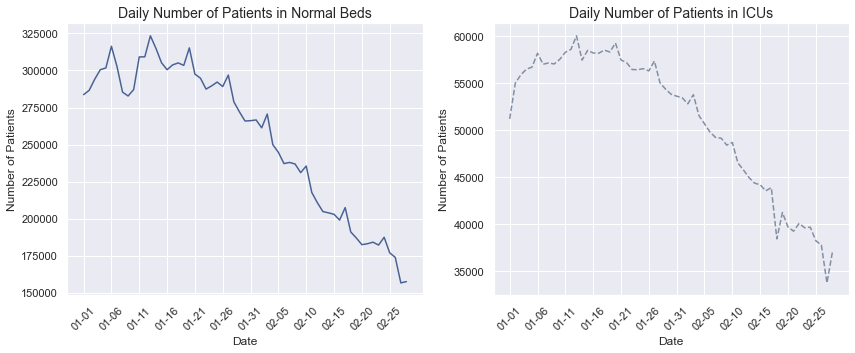

In [25]:
dt_ord = df.orderBy("date", ascending=True).groupBy("date")

hosps = dt_ord.agg(F.sum("hosp_patients")).collect()
hosps = [hosps[i][1] for i in range(len(hosps))]

icus = dt_ord.agg(F.sum("icu_patients")).collect()
icus = [icus[i][1] for i in range(len(icus))]

sns.set(style = "darkgrid")

alt_dts_list = [dt.replace('2021-', '') for dt in dates_list]
tick_marks = np.arange(len(alt_dts_list))

fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(14,5))

for pat, col, style, ax, where in zip([hosps,icus], [mycol, mycomplcol],
                                      ['solid', 'dashed'], [ax1,ax2], ['Normal Beds','ICUs']): 
    ax.plot(alt_dts_list, pat, linestyle=style, color=col)
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of Patients")
    ax.set_title(f"Daily Number of Patients in {where}", fontsize=14)
    ax.set_xticks(tick_marks[::5],alt_dts_list[::5], rotation=45)
    
plt.show()

matplotlib.rc_file_defaults()

Γίνεται εμφανές πως στο υπό μελέτη δίμηνο η τάση σε ό,τι αφορά τις νοσηλείες είναι φθίνουσα, αφού στα τέλη του Φεβρουαρίου οι ασθενείς σε νοσηλεία παγκοσμίως είναι λιγότερο από μισοί σε σχέση με το πλήθος τους κατά τις αρχές του Ιανουαρίου. Αντίστοιχη είναι η εικόνα και για τους διασωληνωμένους, αν και στο τέλος και των δύο διαγραμμάτων φαίνεται να ξεκινά μια νέα ανοδική πορεία. Αξίζει να σημειωθεί πως η συμπεριφορά των δύο διαγραμμάτων είναι όμοια, υποδεικνύοντας μια συσχέτιση ανάμεσα σε πλήθος νοσηλευόμενων και σε πλήθος διασωληνωμένων (όπως είναι ίσως αναμενόμενο), με τη διαφορά πως οι πρώτοι είναι αρκετά περισσότεροι σε σχέση με τους δεύτερους (αφού είναι περισσότερες οι περιπτώσεις σχετικά ηπιότερης νόσησης σε σχέση με τις περιπτώσεις βαριάς νόσησης).

<a id='zht3.6'></a>

#### Ζητούμενο 3.6

> *Να κατασκευάσετε γεωγραφικό θερμοχάρτη (heatmap) του απόλυτου αριθμού κρουσμάτων.*

Ο ζητούμενος γεωγραφικός θερμοχάρτης κατασκευάζεται αξιοποιώντας τη βιβλιοθήκη geopandas, όπως φαίνεται ακολούθως. Στα πλαίσια αυτά, απαιτείται η λήψη ενός shapefile (.shp) το οποίο αποτελεί στην ουσία τη βάση του γεωγραφικού χάρτη και βρίσκεται [εδώ](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/).

In [26]:
import geopandas as gpd

shapefile = 'countries.shp'
geo_df = gpd.read_file(shapefile)[['ADMIN','ADM0_A3','geometry']]
geo_df.columns = ['location', 'iso_code', 'geometry'] # όμοια με το dataframe
geo_df = geo_df.drop(geo_df.loc[geo_df['location'] == 'Antarctica'].index) # Η Ανταρκτική εξαιρείται

Ο ακόλουθος κώδικας κατασκευάζει ένα γεωγραφικό χάρτη με χρωματικό κώδικα που αντιστοιχεί σε πλήθος κρουσμάτων ανά χώρα για κάθε ημερομηνία του διμήνου που εξετάζεται.

In [27]:
print('Εκκίνηση της κατασκευής heatmaps για κάθε ημέρα.')

ct = 0
for this_day in dates_list:
    # Παίρνουμε μονάχα τις δύο επιθυμητές στήλες και τις μετατρέπουμε σε Pandas df ώστε να γίνει το mapping
    day_df = df.filter(F.col('date') == this_day).select(["iso_code","total_cases"]).toPandas()

    merged_df = pd.merge(left=geo_df, right=day_df, how='left', left_on='iso_code', right_on='iso_code')

    title = f'Total COVID-19 Cases as of {this_day}'
    col = 'total_cases'
    vmin, vmax = merged_df[col].min(), merged_df[col].max()
    cmap = mycmap
    divnorm = TwoSlopeNorm(vcenter=0.08*20365726)

    # Create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(20, 8))

    # Remove the axis
    ax.axis('off')
    merged_df.plot(column=col, ax=ax, edgecolor='1.0', linewidth=1, norm=divnorm, cmap=cmap)

    # Add a title
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

    # Empty array for the data range
    sm._A = []

    # Add the colorbar to the figure
    cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
    cbar = fig.colorbar(sm, cax=cbaxes)
    plt.savefig(f'world_map_{this_day}.png', bbox_inches='tight')
    plt.close(fig)
    ct += 1

print(f'Η διαδικασία ολοκληρώθηκε.\nΕξήχθησαν {ct} heatmap(s), που μπορούν τώρα να μετατραπούν σε αρχείο .gif.')

Εκκίνηση της κατασκευής heatmaps για κάθε ημέρα.
Η διαδικασία ολοκληρώθηκε.
Εξήχθησαν 59 heatmap(s), που μπορούν τώρα να μετατραπούν σε αρχείο .gif.


Κατόπιν, οι εικόνες των χαρτών ενώνονται μέσω του λογισμικού Adobe Photoshop, κατασκευάζοντας το ακόλουθο .gif αρχείο, το οποίο απεικονίζει την εξέλιξη ανά ημέρα.

<center> <img src="https://srigas.me/images/covidgif.gif"> </center>

<a id='zht3.7'></a>

#### Ζητούμενο 3.7 & Bonus

> *Να εντοπίσετε παραδείγματα γειτονικών, μεταξύ τους, χωρών, που παρουσιάζουν μέγιστη συσχέτιση υπερβάλλουσας θνησιμότητας (excess mortality);*

Βάσει της τελικής απεικόνισης στο [Ζητούμενο 3.6](#zht3.6), φαίνεται πως ορισμένες γειτονικές χώρες είναι συσχετισμένες ως προς τον αριθμό των κρουσμάτων. Μια εύλογη υπόθεση είναι πως αντίστοιχες συσχετίσεις θα εμφανίζονται και για τις τιμές της υπερβάλλουσας θνησιμότητας.

Η υπερβάλλουσα θνησιμότητα (excess mortality) είναι ένα χαρακτηριστικό για το οποίο τα δεδομένα δίνονται μία φορά την εβδομάδα και ισούται με τους καταγεγραμμένους θανάτους πλην τους αναμενόμενους θανάτους. Δεν είναι ένα χαρακτηριστικό το οποίο αφορά άμεσα τον Covid, όμως εν καιρώ πανδημίας είναι αναμενόμενο η υπερβάλλουσα θνησιμότητα να αποδίδεται ως επί το πλείστον στην πανδημία αυτή.

Προκειμένου να διερευνηθεί η συσχέτιση ανάμεσα σε γειτονικές χώρες ως προς αυτό το χαρακτηριστικό, κατασκευάζεται πρώτα μία λίστα με τις ημερομηνίες κατά τις οποίες τα δεδομένα αυτά είναι διαθέσιμα (σε όλες τις άλλες ημερομηνίες οι καταχωρήσεις είναι μηδενικές, αφού αυτή είναι η τιμή με την οποία είχαν αντικατασταθεί οι απουσιάζουσες τιμές).

In [28]:
exc_dates_list = df.filter(F.col('excess_mortality') != 0.0).select(['date']).distinct().orderBy('date').collect()
exc_dates_list = [str(exc_dates_list[i][0]) for i in range(len(exc_dates_list))]

Δεδομένου πως δεν αναζητούνται όλες οι γειτονικές χώρες του κόσμου με μέγιστη συσχέτιση υπερβάλλουσας θνησιμότητας, μπορεί κανείς να εστιάσει μονάχα σε Ευρωπαϊκές χώρες κατά την αναζήτηση τέτοιων παραδειγμάτων. Αρχικά, κατασκευάζεται ένας γεωγραφικός θερμοχάρτης της Ευρώπης με την υπερβάλλουσα θνησιμότητα κάθε χώρας για καθεμιά εκ των ημερών που βρέθηκε στο προηγούμενο κελί. Κατόπιν, οι προκύπτουσες εικόνες διαμορφώνονται σε ένα αρχείο .gif χρησιμοποιώντας το λογισμικό Adobe Photoshop, όπως έγινε και στο προηγούμενο ζήτημα με τον παγκόσμιο χάρτη.

In [29]:
print('Εκκίνηση της κατασκευής heatmaps για κάθε ημέρα.')

ct = 0
for this_day in exc_dates_list:
    europe_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Europe').filter(F.col('excess_mortality') != 0.0).select(["iso_code","excess_mortality"])
    
    geo_eu = pd.merge(left=geo_df, right=europe_df.toPandas(), how='inner', on='iso_code')

    fig, ax = plt.subplots(1,1)

    col = 'excess_mortality'
    cmap = mycmap

    vmin, vmax = geo_eu[col].min(), geo_eu[col].max()
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

    ax.axis('off')
    ax.axis([-13, 44, 33, 72])
    geo_eu.plot(column=col, ax=ax, edgecolor='1.0', linewidth=1, norm=None, cmap=cmap)
    ax.set_title(f'Excess Mortality in Europe as of {this_day}', fontdict={'fontsize': '14', 'fontweight': '3'})
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=.2)
    fig.add_axes(cax)
    fig.colorbar(sm, cax=cax)
    plt.savefig(f'europe_{this_day}.png', bbox_inches='tight')
    plt.close(fig)
    ct += 1
    
print(f'Η διαδικασία ολοκληρώθηκε.\nΕξήχθησαν {ct} heatmap(s), που μπορούν τώρα να μετατραπούν σε αρχείο .gif.')

Εκκίνηση της κατασκευής heatmaps για κάθε ημέρα.
Η διαδικασία ολοκληρώθηκε.
Εξήχθησαν 9 heatmap(s), που μπορούν τώρα να μετατραπούν σε αρχείο .gif.


Το προκύπτον .gif φαίνεται παρακάτω:

<center> <img src="https://srigas.me/images/europe_excess_mortality.gif"> </center>

Από την άνω απεικόνιση, καθίσταται εμφανές πως πράγματι υπάρχουν γειτονικές χώρες για τις οποίες οι τιμές για την υπερβάλλουσα θνησιμότητα είναι έντονα συσχετισμένες. Ένα χαρακτηριστικό παράδειγμα αποτελούν η Γερμανία με την Ελβετία, αφού φαίνεται να αποκτούν «μαζί» υψηλές ή χαμηλές τιμές για την υπερβάλλουσα θνησιμότητα.

Προκειμένου τα συμπεράσματα αυτά να αποτυπωθούν και με μαθηματική ακρίβεια, παρακάτω κατασκευάζεται ένα νέο PySpark DataFrame, το οποίο περιλαμβάνει τις μετρήσεις υπερβάλλουσας θνησιμότητας για καθεμιά εκ των Ευρωπαϊκών χωρών που διαθέτει δεδομένα **για όλες** τις προηγουμένως υπολογισμένες ημερομηνίες. Χώρες με απουσιάζουσες τιμές σε κάποιες από τις ημερομηνίες αυτές δε λαμβάνονται υπ' όψιν, προκειμένου τα συμπεράσματα να είναι όσο το δυνατό ασφαλέστερα. Κατόπιν, για το συγκεκριμένο DataFrame υπολογίζεται ο πίνακας συσχέτισης, βάσει του οποίου φαίνεται η συσχέτιση Pearson στις τιμές της υπερβάλλουσας θνησιμότητας όλων των υπό μελέτη χωρών μεταξύ τους.

In [30]:
european_df = df.filter(F.col('continent') == 'Europe').filter(F.col('excess_mortality') != 0.0)
european_cts = european_df.select(['location']).distinct().collect()
european_cts = [european_cts[i][0] for i in range(len(european_cts)) if european_df.filter(F.col('location') == european_cts[i][0]).count() == len(exc_dates_list)]
print(f'Στα πλαίσια της ανάλυσης αυτής, επιλέγονται {len(european_cts)} Ευρωπαϊκές χώρες.')

Στα πλαίσια της ανάλυσης αυτής, επιλέγονται 31 Ευρωπαϊκές χώρες.


In [31]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

eu_cts_df = european_df.filter(F.col('location') == european_cts[0]).select(['excess_mortality']).withColumnRenamed("excess_mortality", european_cts[0])
# αυτό απαιτείται ώστε τα ακόλουθα DataFrames να μπορούν να "κολλήσουν" κατάλληλα μέσω ενός join
eu_cts_df = eu_cts_df.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

for country in european_cts[1:]:
    new_ct_df = european_df.filter(F.col('location') == country).select(['excess_mortality']).withColumnRenamed("excess_mortality", country)
    new_ct_df = new_ct_df.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
    
    eu_cts_df = eu_cts_df.join(new_ct_df, on=["row_index"])
    
eu_cts_df = eu_cts_df.drop("row_index")

In [32]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

import warnings
warnings.filterwarnings("ignore") # To ignore a FutureWarning raised below

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=eu_cts_df.columns, outputCol=vector_col)
df_vector = assembler.transform(eu_cts_df).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col, 'pearson')
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

Ο υπολογισμένος πίνακας συσχέτισης απεικονίζεται στο ακόλουθο heatmap. Υπ' όψιν λαμβάνονται <u>μόνο τιμές της συσχέτισης μεγαλύτερες του 0.8</u> (καθώς αναζητούνται χώρες που εμφανίζουν μεταξύ τους υψηλή συσχέτιση), γι' αυτό και το σχετικό colorbar έχει ως κάτω του άκρο την τιμή αυτή.

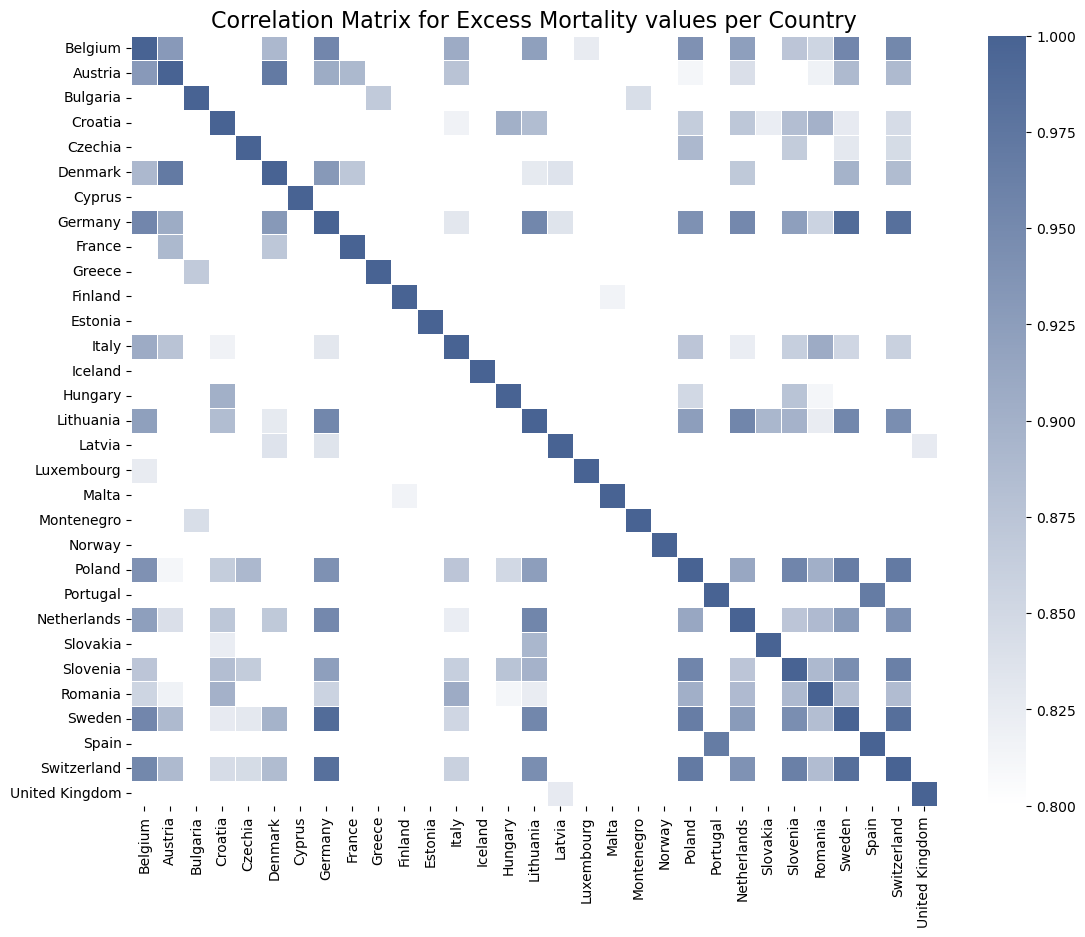

In [33]:
fig, ax = plt.subplots(figsize=(13,10))

sns.heatmap(cor_np, linewidths=.5, ax=ax, vmin=0.8, vmax=1, cmap=mycmap,
            xticklabels=european_cts, yticklabels=european_cts)
ax.set_title('Correlation Matrix for Excess Mortality values per Country', fontsize=16)
plt.show()

Όπως παρατηρήθηκε και πριν την κατασκευή του πίνακα συσχέτισης, η Ελβετία και η Γερμανία πράγματι αποτελούν ένα ζεύγος γειτονικών χωρών με υψηλή συσχέτιση σε ό,τι αφορά τις τιμές για την υπερβάλλουσα θνησιμότητα. Μάλιστα, φαίνεται πως στις περισσότερες περιπτώσεις η υψηλή συσχέτιση εμφανίζεται ανάμεσα σε γειτονικές μεταξύ τους χώρες (π.χ. Βέλγιο με Γερμανία, Λουξεμβούργο και Ολλανδία), **καθώς και γείτονες των γειτονικών τους χωρών**. Θα μπορούσε δηλαδή κανείς να ισχυριστεί πως η συσχέτιση αυτή στις περισσότερες περιπτώσεις δε φθίνει σε εύρος πρώτων γειτόνων, αλλά επεκτείνεται και σε > 1 γείτονες. Μερικά ακόμη τέτοια παραδείγματα (όχι όλες οι περιπτώσεις που φαίνονται στον άνω πίνακα) Ευρωπαϊκών ζευγών παρατίθενται στον ακόλουθο πίνακα, μαζί με τις αντίστοιχες τιμές για τη συσχέτιση Pearson.

| | Συσχέτιση Pearson για τιμές υπερβάλλουσας Θνησιμότητας (%) |
| :-: | :-: |
| **Γερμανία & Ελβετία** | 98.29 |
| **Γερμανία & Βέλγιο** | 95.44 |
| **Λιθουανία & Πολωνία** | 92.50 |
| **Ολλανδία & Βέλγιο** | 92.30 |
| **Τσεχία & Πολωνία** | 89.08 |
| **Ελλάδα & Βουλγαρία** | 86.87 |
| **Ιταλία & Σλοβενία** | 86.23 |


Για μια πιο εξαντλητική λίστα των Ευρωπαϊκών χωρών με υψηλή μεταξύ τους συσχέτιση, η οποία δεν περιορίζεται μόνο σε γειτονικές χώρες, μπορεί κανείς να τρέξει τον ακόλουθο κώδικα:

```
for i in range(len(european_cts)):
    for j in range(i+1,len(european_cts)):
        corr_val = cor_np[i][j]
        if corr_val > 0.8:
            print(f'Η χώρα {european_cts[i]} και η χώρα {european_cts[j]} εμφανίζουν μεταξύ τους συσχέτιση ίση με {100*corr_val:.2f}.')
```

<a id='zht3.8'></a>

#### Ζητούμενο 3.8 & Bonus

> *Εκτιμήστε την εξάπλωση της λοίμωξης μέσω του ρυθμού αναπαραγωγής (reproduction rate) σε όλες τις Ηπείρους πλην Ανταρκτικής.*

Στα πλαίσια του ζητήματος αυτού, οι χώρες θα πρέπει να χωριστούν ανά ηπείρους. Για το σκοπό αυτό, το υπάρχον DataFrame χωρίζεται σε επί μέρους, προκειμένου να είναι εφικτή η επεξεργασία σε επίπεδο ηπείρου, καθώς και ο σχεδιασμός ξεχωριστών χαρτών. Για κάθε ημέρα στη διάρκεια Ιανουαρίου-Φεβρουαρίου 2021 υπολογίζεται η μέση τιμή του ρυθμού αναπαραγωγής ανά ήπειρο. Επιπλέον, για κάθε ήπειρο σχεδιάζεται ενα ξεχωριστό heatmap, με κοινό όμως colorbar, προκειμένου να είναι εφικτή η σύγκριση του ρυθμού αναπαραγωγής από ήπειρο σε ήπειρο. Τέλος, όπως και προηγουμένως, όλες οι εικόνες των colormaps επεξεργάζονται μέσω Adobe Photoshop για την κατασκευή ενός .gif στο οποίο φαίνεται η εξέλιξη του ρυθμού αναπαραγωγής στη διάρκεια των δύο μηνών.

Σημειώνεται πως, παρότι όλα τα filterings πραγματοποιούνται μέσω PySpark queries, οι πράξεις join μεταξύ των DataFrames των χωρών με το GeoPandas DataFrame είναι οι μόνες που πραγματοποιούνται μέσω της pandas, καθώς [η PySpark δε μπορεί να αναγνωρίσει τη στήλη που αφορά τη γεωμετρία των χωρών](https://ncar.github.io/PySpark4Climate/tutorials/pyspark-geo-analysis/geopandas-and-spark/) για την κατασκευή του αντίστοιχου χάρτη.

In [34]:
daily_means = {'AS': [], 'EU' : [], 'NAM' : [], 'SAM' : [], 'OC' : [], 'AF' : []}

print('Εκκίνηση της κατασκευής heatmaps για κάθε ημέρα.')

ct = 0
for this_day in dates_list:
    asia_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Asia').filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    europe_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Europe').filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    namerica_df = df.filter(F.col('date') == this_day).filter((F.col('continent') == 'North America')).filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    samerica_df = df.filter(F.col('date') == this_day).filter((F.col('continent') == 'South America')).filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    oceania_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Oceania').filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])
    africa_df = df.filter(F.col('date') == this_day).filter(F.col('continent') == 'Africa').filter(F.col('reproduction_rate') != 0.0).select(["iso_code","reproduction_rate"])

    daily_means['AS'].append(asia_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['EU'].append(europe_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['NAM'].append(namerica_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['SAM'].append(samerica_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['OC'].append(oceania_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])
    daily_means['AF'].append(africa_df.select(F.mean(F.col('reproduction_rate'))).collect()[0][0])

    geo_as = pd.merge(left=geo_df, right=asia_df.toPandas(), how='inner', on='iso_code')
    geo_eu = pd.merge(left=geo_df, right=europe_df.toPandas(), how='inner', on='iso_code')
    geo_sam = pd.merge(left=geo_df, right=samerica_df.toPandas(), how='inner', on='iso_code')
    geo_nam = pd.merge(left=geo_df, right=namerica_df.toPandas(), how='inner', on='iso_code')
    geo_oc = pd.merge(left=geo_df, right=oceania_df.toPandas(), how='inner', on='iso_code')
    geo_af = pd.merge(left=geo_df, right=africa_df.toPandas(), how='inner', on='iso_code')

    fig, axes = plt.subplots(2,3, figsize=(18,14))

    col = 'reproduction_rate'
    cmap = mycmap

    vmin = min(geo_as[col].min(),geo_eu[col].min(),geo_sam[col].min(),geo_nam[col].min(),geo_oc[col].min(),geo_af[col].min())
    vmax = max(geo_as[col].max(),geo_eu[col].max(),geo_sam[col].max(),geo_nam[col].max(),geo_oc[col].max(),geo_af[col].max())
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

    for ax, data, cont, dims in zip(axes.flat,
                               [geo_eu, geo_nam, geo_af, geo_as, geo_sam, geo_oc],
                               ['Europe','North America','Africa','Asia','South America','Oceania'],
                               [[-13, 44, 33, 72],[-170, -50, 5, 85],[-20, 55, -38, 40],[25, 145, -10, 60],[-85, -32, -58, 15],[110,160,-45,0]]):
        title = f'{cont}'
        ax.axis('off')
        ax.axis(dims)
        data.plot(column=col, ax=ax, edgecolor='1.0', linewidth=1, norm=None, cmap=cmap)
        ax.set_title(title, fontdict={'fontsize': '18', 'fontweight': '3'})

    clb = fig.colorbar(sm, ax=axes.flat, location='bottom', fraction=0.056)
    clb.ax.set_title(f'COVID-19 Reproduction Rate as of {this_day}', fontsize=22)
    plt.savefig(f'cont_maps_{this_day}.png', bbox_inches='tight')
    plt.close(fig)
    ct += 1

print(f'Η διαδικασία ολοκληρώθηκε.\nΕξήχθησαν {ct} heatmap(s), που μπορούν τώρα να μετατραπούν σε αρχείο .gif.')

Εκκίνηση της κατασκευής heatmaps για κάθε ημέρα.
Η διαδικασία ολοκληρώθηκε.
Εξήχθησαν 59 heatmap(s), που μπορούν τώρα να μετατραπούν σε αρχείο .gif.


Το .gif που απεικονίζει τον καθημερινό ρυθμό αναπαραγωγής ανά χώρα και ήπειρο είναι το ακόλουθο:

<center> <img src="https://srigas.me/images/daily_covid_reproduction.gif"> </center>

Σε διηπειρωτικό επίπεδο, φαίνεται η Αυστραλία να εμφανίζει στην υπό μελέτη διάρκεια τις υψηλότερες αλλά και τις χαμηλότερες τιμές για το ρυθμό αναπαραγωγής. Στις υπόλοιπες ηπείρους υπάρχουν επίσης αυξομειώσεις, αν και όχι τόσο έντονες, με τη γενική εικόνα να είναι πως ο ρυθμός αναπαραγωγής είναι υψηλότερος τις τελευταίες ημέρες του Φεβρουαρίου σε σχέση με τις πρώτες ημέρες του Ιανουαρίου, υποδεικνύοντας έτσι μια ανησυχητική τάση της πανδημίας. Χαρακτηριστικό παράδειγμα αυτού αποτελεί η Νότια Αμερική, όπου ο ρυθμός αναπαραγωγής φαίνεται με το πέρασμα του χρόνου να σταθεροποιείται προς υψηλές τιμές. Από την άλλη, εντοπίζεται ως εξαίρεση η Βόρεια Αμερική (στην οποία οι αυξομειώσεις πραγματοποιούνται ομοιόμορφα σε όλες τις χώρες της), για την οποία ο ρυθμός αναπαραγωγής φαίνεται να έχει μειωθεί συνολικά από τις αρχές του Ιανουαρίου μέχρι τα τέλη του Φεβρουαρίου.

Σε επίπεδο χωρών, οι χώρες της Ασίας έχουν μια τάση η οποία επαληθεύει την ύπαρξη συσχέτισης μεταξύ γειτονικών χωρών που μελετήθηκε στο [Ζητούμενο 3.7](#zht3.7) για την περίπτωση της υπερβάλλουσας θνησιμότητας. Μάλιστα, στις περισσότερες περιπτώσεις η συσχέτιση αυτή αφορά και γείτονες τάξης μεγαλύτερης του 1, κάτι το οποίο οπτικά επαληθεύεται από τις ομοιόμορφες αυξομειώσεις που παρατηρούνται και στις χώρες της Βόρειας Αμερικής. Στην Ευρώπη ενδιαφέρον παρουσιάζει το γεγονός πως, ενώ στις αρχές του Ιανουαρίου η Πορτογαλία και η Ισπανία εμφανίζουν υψηλές τιμές του ρυθμού αναπαραγωγής σε αντίθεση με τις υπόλοιπες χώρες, η συμπεριφορά αυτή αντιστρέφεται με το πέρας της υπό μελέτη χρονικής περιόδου. Η παρατήρηση αυτή μπορεί ίσως να αποδοθεί στη διαχείριση των δύο αυτών χωρών μετά τα έντονα πλήγματα που δέχθηκαν κατά τα πρώτα κύματα της πανδημίας, καθώς και [στην αποδοτικότητά τους στο να προσφέρουν εμβολιαστική κάλυψη](https://apnews.com/article/coronavirus-pandemic-lifestyle-health-europe-portugal-66ad07ae486a8c396cf8a8f72eb8e30f) στον πληθυσμό τους.

Παρότι το παραπάνω .gif δίνει μια αναλυτική εικόνα της πορείας του ρυθμού αναπαραγωγής σε κάθε χώρα, μια μελέτη που επικεντρώνεται αποκλειστικά σε επίπεδο ηπείρων μπορεί να οδηγήσει σε επιπλέον συμπεράσματα. Για το σκοπό αυτό, απεικονίζονται παρακάτω οι χρονοσειρές της μέσης τιμής του μέσου ρυθμού αναπαραγωγής του ιού για κάθε ήπειρο.

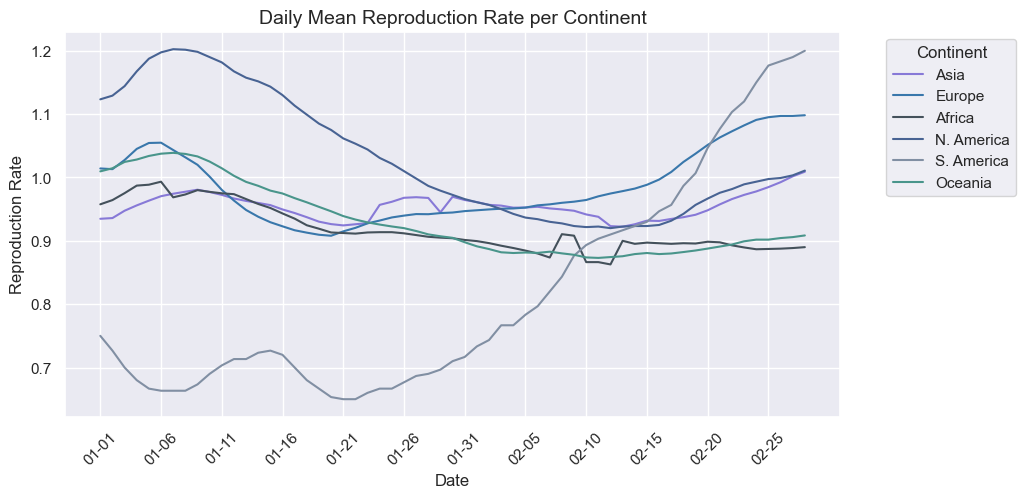

In [35]:
sns.set(style = "darkgrid")

fig, ax = plt.subplots(1, 1, figsize=(10,5))

for key, col, lab in zip(daily_means,
                             [othercol1, othercol2, othercol3, mycol, mycomplcol, othercol4],
                             ['Asia', 'Europe', 'Africa', 'N. America', 'S. America', 'Oceania']): 
    ax.plot(alt_dts_list, daily_means[key], color=col, label = lab)
    
ax.set_xlabel("Date")
ax.set_ylabel("Reproduction Rate")
ax.set_title("Daily Mean Reproduction Rate per Continent", fontsize=14)
tick_marks = np.arange(len(alt_dts_list))
ax.set_xticks(tick_marks[::5],alt_dts_list[::5], rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, title="Continent")
plt.show()

matplotlib.rc_file_defaults()

Οι τάσεις και οι αυξομειώσεις που σχολιάστηκαν παραπάνω γίνονται εύκολα αντιληπτές από το γράφημα αυτό. Για παράδειγμα, είναι εμφανής η μέση τάση προς αυξημένες τιμές του ρυθμού αναπαραγωγής για όλες τις ηπείρους πλην της Βόρειας Αμερικής. Εντούτοις, μια πρόσθετη πληροφορία που προσφέρει το παραπάνω διάγραμμα είναι πως κατά τις τελευταίες ημέρες του Φεβρουαρίου ο μέσος ρυθμός αναπαραγωγής για τις χώρες της Βόρειας Αμερικής τείνει να αυξηθεί. Το ίδιο ισχύει και για τις χώρες της Ασίας, αλλά και της Νότιας Αμερικής. Ειδικά για τις χώρες της Νότιας Αμερικής, η συνολική ποσοστιαία αύξηση του μέσου ρυθμού αναπαραγωγής κατά τη διάρκεια του υπό μελέτη διμήνου ήταν περίπου 60%, πράγμα το οποίο σημαίνει πως αυτό το ποσοστό ενδέχεται να αυξήθηκε ακόμη περισσότερο κατά τον Μάρτιο, βάσει της παρατηρούμενης τάσης. Από την άλλη, για την Ωκεανία, την Αφρική και την Ευρώπη παρατηρείται μια τάση προς σταθεροποίηση. Κλείνοντας, αξίζει να αναφερθεί πως εκ πρώτης όψεως οι έντονες αυξομειώσεις που παρατηρήθηκαν για την Ωκεανία στο παραπάνω .gif δε συνάδουν με τη σχεδόν σταθερή εικόνα που παρουσιάζεται στο γράφημα. Παρ' όλα αυτά δεν υπάρχει καμία ασυνέπεια: ο μέσος όρος εξάγεται με απλή διαίρεση με το πλήθος των χωρών και όχι με μια στάθμιση ως προς τον πληθυσμό τους. Αυτό σημαίνει πως η συνεισφορά της Αυστραλίας και της Παπούα Νέας Γουινέας θεωρούνται ισοδύναμες στην εξαγωγή του μέσου αυτού όρου. Έτσι, η σταθερή εικόνα του γραφήματος αποδίδεται στην αντίστροφη τάση των δύο αυτών χωρών ως προς το ρυθμό αναπαραγωγής (όταν η τιμή του είναι υψηλή στην Παπούα Νέα Γουινέα, η αντίστοιχη τιμή είναι χαμηλή στην Αυστραλία και αντιστρόφως).

<a id='zht3.9'></a>

#### Ζητούμενο 3.9

> *Εμφανίστε τους καθημερινούς διαγνωστικούς ελέγχους ανά χώρα.*

Παρακάτω εμφανίζονται οι καθημερινοί διαγνωστικοί έλεγχοι ανά χώρα για κάθε ημέρα που αντιστοιχεί στο υπό μελέτη σύνολο δεδομένων. Η μεταβλητή `new_tests_smoothed` επιλέγεται έναντι της `new_tests`, καθώς η δεύτερη εμφανίζει περισσότερες απουσιάζουσες τιμές (οι οποίες αντικαταστάθηκαν με μηδενικά κατά την προεπεξεργασία). Για παράδειγμα, η Γερμανία έχει μόνο απουσιάζουσες τιμές στη στήλη `new_tests`, ενώ η αντίστοιχη στήλη `new_tests_smoothed` είναι πλήρως συμπληρωμένη.

In [36]:
df.orderBy("date", ascending=True).select(["date", "location", "new_tests_smoothed"]).show(10)

+----------+--------------------+------------------+
|      date|            location|new_tests_smoothed|
+----------+--------------------+------------------+
|2021-01-01|      United Kingdom|          382754.0|
|2021-01-01|             Vanuatu|               0.0|
|2021-01-01|              Turkey|          176533.0|
|2021-01-01|             Ukraine|           25644.0|
|2021-01-01|United Arab Emirates|          143691.0|
|2021-01-01|Turks and Caicos ...|               0.0|
|2021-01-01|              Uganda|            3039.0|
|2021-01-01|       United States|         1502075.0|
|2021-01-01| Upper middle income|               0.0|
|2021-01-01|             Uruguay|            5962.0|
+----------+--------------------+------------------+
only showing top 10 rows



<a id='zht3.10'></a>

#### Ζητούμενο 3.10

> *Να μελετήσετε τη συσχέτιση μεταξύ του πλήθους των ελέγχων για κορονοϊό και της υπερβάλλουσας θνησιμότητας και να εμφανίσετε τις χώρες με τη μεγαλύτερη και τη μικρότερη συσχέτιση.*

Ο τρόπος με τον οποίο μελετάται η συσχέτιση αυτή είναι μέσω της κατασκευής μιας λίστας με χώρες παγκοσμίως και υπολογισμού της ζητούμενης συσχέτισης για καθεμιά από αυτές. Τα χαρακτηριστικά που χρησιμοποιούνται είναι το `excess_mortality` και το `new_tests_smoothed`. Η επιλογή του `new_tests_smoothed` έναντι του `new_tests` γίνεται και σε αυτήν την περίπτωση για το λόγο που αναλύθηκε και παραπάνω. Δεδομένου πως η ανάλυση γίνεται σε επίπεδο χώρας, δεν υπάρχει λόγος να χρησιμοποιηθούν κανονικοποιημένα χαρακτηριστικά, αφού η τελική μετρική είναι μια τιμή συσχέτισης μεταξύ χαρακτηριστικών που αφορούν την ίδια χώρα.

Σημειώνεται πως για την ανάλυση αυτή επιλέγονται χώρες που κατά το υπό μελέτη δίμηνο έχουν περισσότερες από 5 **μη μηδενικές** καταχωρήσεις για το χαρακτηριστικό `excess_mortality` (σε αντιστοιχία με όσα έγιναν στο [Ζητούμενο 3.7](#zht3.7), όπου λήφθηκαν υπ' όψιν μόνο χώρες χωρίς μηδενικές καταχωρήσεις για την υπερβάλλουσα θνησιμότητα). Χωρίς τον επιπλέον αυτό έλεγχο, πάρα πολλές χώρες φαίνεται να αποκτούν τη μέγιστη/ελάχιστη τιμή +1/-1 για την υπό διερεύνηση συσχέτιση, μόνο και μόνο επειδή έχουν ελάχιστες καταχωρήσεις (υπενθυμίζεται πως το `excess_mortality` και τα συγγενικά του χαρακτηριστικά ήταν ανάμεσα σε αυτά με τις περισσότερες απουσιάζουσες τιμές πριν αυτές αντικατασταθούν με την τιμή 0). Χαρακτηριστικό παράδειγμα είναι αυτό της Αλβανίας, για την οποία η συσχέτιση προκύπτει ίση με +1, απλώς επειδή έχει μόλις 2 καταχωρήσεις για το χαρακτηριστικό `excess_mortality` κατά τους μήνες Ιανουάριο-Φεβρουάριο 2021.

In [37]:
countries_frame = df.select("location").distinct().collect()
exclusion_list = ['Europe', 'World', 'Asia', 'North America', 'South America', 'Africa', 'Oceania', 'Upper middle income']
countries_list = [str(countries_frame[x][0]) for x in range(len(countries_frame)) if str(countries_frame[x][0]) not in exclusion_list]

In [38]:
country_dict = {}
for country in countries_list:
    filtered = df.filter(F.col('location') == country).filter(F.col('excess_mortality') != 0.0)
    if filtered.count() > 5:
        value = filtered.stat.corr("excess_mortality", "new_tests_smoothed")
    else:
        value = np.nan
    if not np.isnan(value):
        country_dict[country] = value

In [39]:
country_dict = dict(sorted(country_dict.items(), reverse=True, key=lambda item: item[1]))
print("Σε ό,τι αφορά τη συσχέτιση μεταξύ πλήθους ελέγχων και υπερβάλλουσας θνησιμότητας:\n")
print("Οι δέκα χώρες με την υψηλότερη συσχέτιση είναι οι:")
for i, ct in enumerate(country_dict):
    if i == 10: break
    print(f"{ct}, με συσχέτιση {country_dict[ct]:.3f}.")
country_dict = dict(sorted(country_dict.items(), reverse=False, key=lambda item: item[1]))
print("\nΟι δέκα χώρες με τη χαμηλότερη συσχέτιση είναι οι:")
for i, ct in enumerate(country_dict):
    if i == 10: break
    print(f"{ct}, με συσχέτιση {country_dict[ct]:.3f}.")

Σε ό,τι αφορά τη συσχέτιση μεταξύ πλήθους ελέγχων και υπερβάλλουσας θνησιμότητας:

Οι δέκα χώρες με την υψηλότερη συσχέτιση είναι οι:
Spain, με συσχέτιση 0.976.
South Africa, με συσχέτιση 0.968.
Portugal, με συσχέτιση 0.960.
Mexico, με συσχέτιση 0.921.
Colombia, με συσχέτιση 0.916.
United States, με συσχέτιση 0.794.
Lithuania, με συσχέτιση 0.763.
South Korea, με συσχέτιση 0.716.
Ecuador, με συσχέτιση 0.646.
Chile, με συσχέτιση 0.637.

Οι δέκα χώρες με τη χαμηλότερη συσχέτιση είναι οι:
Slovakia, με συσχέτιση -0.879.
Denmark, με συσχέτιση -0.820.
Romania, με συσχέτιση -0.819.
New Zealand, με συσχέτιση -0.733.
Switzerland, με συσχέτιση -0.715.
Italy, με συσχέτιση -0.706.
Sweden, με συσχέτιση -0.643.
Luxembourg, με συσχέτιση -0.543.
Austria, με συσχέτιση -0.396.
Cyprus, με συσχέτιση -0.371.


Για τις χώρες στις οποίες η συσχέτιση είναι θετική και πλησιάζει τη μονάδα, η αυξημένη υπερβάλλουσα θνησιμότητα φαίνεται να συνδέεται με έναν αυξημένο αριθμό διαγνωστικών ελέγχων και αντιστρόφως. Αυτό ενδέχεται να αφορά χώρες οι οποίες μέχρι εκείνες τις ημερομηνίες είχαν πληγεί σημαντικά από την πανδημία, επομένως πραγματοποιούσαν αυξημένους αριθμούς διαγνωστικών ελέγχων, προκειμένου να είναι σε θέση να ανακόψουν την έξαρση του ιού μέσω άμεσης απομόνωσης των κρουσμάτων και κατάλληλης ιχνηλάτησης. [Όπως είναι γνωστό](https://pubmed.ncbi.nlm.nih.gov/33334400/), η Πορτογαλία και η Ισπανία αποτελούν τέτοιες περιπτώσεις.

Από την άλλη, στις χώρες όπου η τάση είναι αντίστροφη, είτε παρά την υψηλή υπερβάλλουσα θνησιμότητα τα μέτρα για διενέργεια διαγνωστικών ελέγχων δεν ήταν επαρκή (π.χ. Ρουμανία), είτε παρά τη χαμηλή υπερβάλλουσα θνησιμότητα διενεργούνταν πάρα πολλοί διαγνωστικοί έλεγχοι για λόγους πρόληψης (π.χ. Νέα Ζηλανδία ή Λουξεμβούργο).

<a id='zht3.11'></a>

#### Ζητούμενο 3.11

> *Συσταδοποιείστε τις χώρες σε ομάδες ως προς τον αριθμό κρουσμάτων ανά εκατομμύριο και ως προς της υπερβάλλουσας θνησιμότητας ανά εκατομμύριο. Αναλύστε συνοπτικά τα ποιοτικά χαρακτηριστικά των συστάδων που λαμβάνετε.*

Αρχικά, όπως και στα προηγούμενα ζητούμενα που αφορούσαν την υπερβάλλουσα θνησιμότητα, θα επιλεγούν μονάχα χώρες για τις οποίες το συγκεκριμένο χαρακτηριστικό είναι μη μηδενικό. Η συσταδοποίηση θα πραγματοποιηθεί σε δύο ημερομηνίες: την πρώτη και την τελευταία ημέρα για την οποία υπάρχουν μη μηδενικά δεδομένα της υπερβάλλουσας θνησιμότητας. Ο λόγος για αυτό είναι προκειμένου να φανεί χρονικά η μεταβολή στον τρόπο με τον οποίο συσταδοποιούνται οι χώρες δεδομένων των χαρακτηριστικών αυτών.

Προκειμένου να προχωρήσει κανείς στη συσταδοποίηση, η οποία είναι η κατ' εξοχήν μη επιβλεπόμενη μέθοδος μηχανικής μάθησης, ένα από τα σημαντικά ερωτήματα που καλείται να διερευνήσει είναι το πλήθος συστάδων που θα υποθέσει. Δεδομένου πως στο παρόν πρόβλημα δεν υπάρχουν διαθέσιμες ετικέτες για τα δεδομένα ως προς το σε ποια συστάδα ανήκουν, δεν υπάρχει η δυνατότητα αξιολόγησης διαφορετικών μεταξύ τους συσταδοποιήσεων αξιοποιώντας τεχνικές όπως η Elbow, μιας και δεν υπάρχει τρόπος να μετρηθεί το κόστος/η απώλεια από κάθε συσταδοποίηση. Έτσι, το πρώτο βήμα θα είναι η κατασκευή διαγραμμάτων διασποράς των χωρών που πληρούν τα προαναφερθέντα κριτήρια για τις δύο υπό μελέτη ημερομηνίες, προκειμένου το πλήθος συστάδων να προσδιοριστεί μέσω ενός οπτικού ελέγχου.

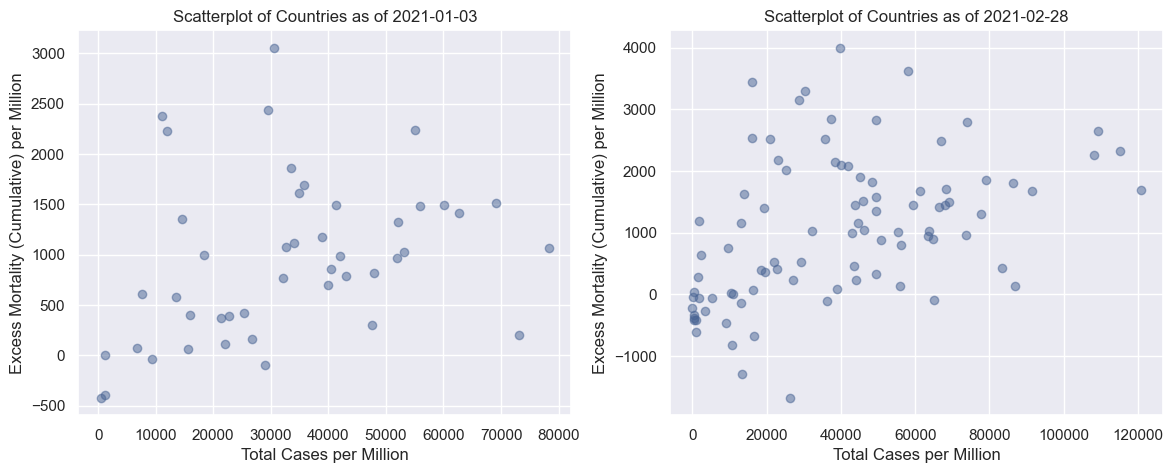

In [40]:
sns.set(style = "darkgrid")
    
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(14,5))

for idx, (ax,this_day) in enumerate(zip([ax1,ax2],[exc_dates_list[0],exc_dates_list[-1]])):
    
    eff_df = df.filter(F.col('excess_mortality_cumulative_per_million') != 0.0).filter(F.col('date') == this_day).select(['total_cases_per_million','excess_mortality_cumulative_per_million','location'])

    pdf = eff_df.select(['total_cases_per_million','excess_mortality_cumulative_per_million']).toPandas()

    points = ax.scatter(pdf.total_cases_per_million, pdf.excess_mortality_cumulative_per_million,
                                  color=mycol, alpha=0.5)

    ax.set_title(f'Scatterplot of Countries as of {this_day}')
    ax.set_xlabel('Total Cases per Million')
    ax.set_ylabel('Excess Mortality (Cumulative) per Million')

plt.show()

matplotlib.rc_file_defaults()

Ήδη από αυτήν την προκαταρκτική οπτικοποίηση, εξάγεται ένα πολύ σημαντικό συμπέρασμα που αφορά τα ίδια τα δεδομένα: το πλήθος χωρών που αναφέρουν τα ποσοστά υπερβάλλουσας θνησιμότητας αυξήθηκε από τις αρχές του Ιανουαρίου μέχρι τα τέλη του Φεβρουαρίου, αφού το δεύτερο διάγραμμα έχει αισθητά περισσότερα σημεία.

Σε ό,τι αφορά το πλήθος των υπό μελέτη συστάδων, για την πρώτη ημερομηνία είναι μάλλον λογική η υπόθεση των δύο συστάδων: μια που να περιλαμβάνει τα λιγότερα περιστατικά ανά εκατομμύριο και μια που να περιλαμβάνει τα περισσότερα, αφού - με εξαίρεση ορισμένες έκτοπες τιμές - η υπερβάλλουσα θνησιμότητα φαίνεται να ακολουθεί το σύνολο περιστατικών αναλογικά. Από την άλλη, η κατάσταση είναι πιο σύνθετη για τη δεύτερη ημερομηνία. Εκεί, θα επιλεγούν 3 συστάδες, η μία εκ των οποίων αναμένεται να περιλαμβάνει τις 4 χώρες με πολύ υψηλό αριθμό συνολικών περιστατικών που φαίνονται στο άνω διάγραμμα διασποράς. Οι υπόλοιπες δύο θα πρέπει να διαχωρίζουν κατάλληλα τις υπόλοιπες χώρες.

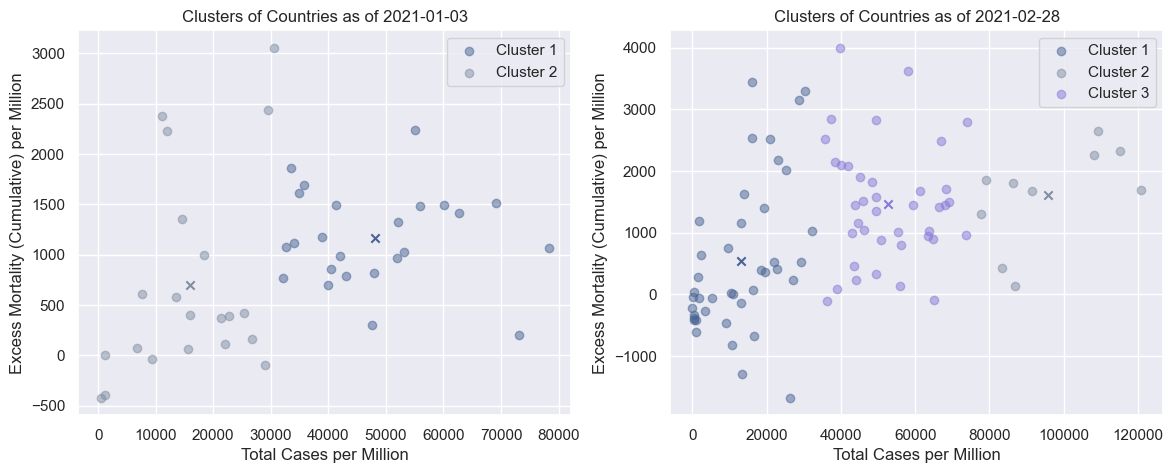

In [41]:
from pyspark.ml.clustering import KMeans

sns.set(style = "darkgrid")

numclusters = [2,3]
colors = [mycol, mycomplcol, othercol1, othercol2, othercol3, othercol4]
    
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(14,5))

for idx, (ax,this_day) in enumerate(zip([ax1,ax2],[exc_dates_list[0],exc_dates_list[-1]])):
    
    eff_df = df.filter(F.col('excess_mortality_cumulative_per_million') != 0.0).filter(F.col('date') == this_day).filter(F.col('date') == this_day).select(['total_cases_per_million','excess_mortality_cumulative_per_million','location'])

    vectorAssembler = VectorAssembler(inputCols = ['total_cases_per_million','excess_mortality_cumulative_per_million'], outputCol = "features")
    feat_df = vectorAssembler.transform(eff_df)
    feat_df = feat_df.select(['features','location'])

    kmeans = KMeans().setK(numclusters[idx]).setSeed(1).setFeaturesCol("features").setPredictionCol("cluster")
    model = kmeans.fit(feat_df)
    transformed = model.transform(feat_df)
    centroids = model.clusterCenters()

    transformed = transformed.join(eff_df, 'location')
    
    clusters, centers, images = {}, {}, {}

    for i in range(numclusters[idx]):

        clusters[i] = transformed.filter(F.col('cluster')==i).select(['location','cluster','total_cases_per_million',
                                                              'excess_mortality_cumulative_per_million']).toPandas().set_index('location')

        images[i] = ax.scatter(clusters[i].total_cases_per_million, clusters[i].excess_mortality_cumulative_per_million,
                                  color=colors[i], alpha=0.5)
        centers[i] = ax.scatter(centroids[i][0], centroids[i][1], color=colors[i], marker='x')

    clusttuple = (images[i] for i in range(numclusters[idx]))
    clustnames = ('Cluster '+str(i+1) for i in range(numclusters[idx]))

    ax.legend(clusttuple, clustnames, loc='best')

    ax.set_title(f'Clusters of Countries as of {this_day}')
    ax.set_xlabel('Total Cases per Million')
    ax.set_ylabel('Excess Mortality (Cumulative) per Million')

plt.show()

matplotlib.rc_file_defaults()

Σε κάθε περίπτωση οι διαφορετικές συστάδεις απεικονίζονται με διαφορετικά χρώματα, ενώ τα κέντρα κάθε συστάδας συμβολίζονται με `X`. Για τις αρχές του Ιανουαρίου οι χώρες πράγματι μοιράζονται στις δύο συστάδες όπως θα ανέμενε κανείς και από την αρχική οπτικοποίηση.

Σε ό,τι αφορά τα τέλη Φεβρουαρίου, πράγματι μία συστάδα περιλαμβάνει τις 4 χώρες για τις οποίες τα συνολικά περιστατικά ξεπερνούσαν τις 100.000. Όλες οι χώρες που ανήκουν στη συστάδα αυτή είναι οι:

In [42]:
print(*clusters[1].index, sep=', ')

Czechia, Israel, Luxembourg, Montenegro, Panama, Portugal, San Marino, Slovakia, Slovenia, United States


Φαίνεται πως οι 4 χώρες με κρούσματα ανά εκατομμύριο άνω των 100.000 δεν αποτελούν outliers αλλά πραγματικά μέλη της συστάδας αυτής, αφού η συστάδα περιλαμβάνει τις χώρες με τον υψηλότερο αριθμό κρουσμάτων κατά τα τέλη του Φεβρουαρίου, όπως προσδιορίστηκαν και στο [Ζητούμενο 3.2](#zht3.2). Οι μικρές διαφορές οφείλονται ενδεχομένως στο γεγονός πως λίγες από τις χώρες που περιλαμβάνονταν στη δεκάδα του ζητουμένου αυτού δεν διέθεταν πληροφορίες σχετικά με την υπερβάλλουσα θνησιμότητα και ως εκ τούτου δεν συμπεριλήφθηκαν στα παραπάνω διαγράμματα.

Σε ό,τι αφορά τις άλλες δύο συστάδες, φαίνεται η συσταδοποίηση να βασίζεται κυρίως στον οριζόντιο άξονα, δηλαδή το σύνολο κρουσμάτων ανά εκατομμύριο. Στη συστάδα με κέντρο τα ~53000 κρούσματα ανά εκατομμύριο οι 30 από τις 39 συνολικά χώρες είναι Ευρωπαϊκές χώρες. Από την άλλη, στη συστάδα με κέντρο τα ~13000 υπάρχουν χώρες από όλον τον κόσμο, συμπεριλαμβανομένων ορισμένων Ευρωπαϊκών, αλλά αυτές δεν ανήκουν σε καμία περίπτωση στη συντριπτική πλειοψηφία, όπως στην περίπτωση της άλλης μεγάλης συστάδας.

<a id='zht3.12'></a>

#### Ζητούμενο 3.12

> *Να υπολογίσετε τη συσχέτιση μεταξύ πορείας εμβολιασμών (αν υπάρχουν την χρονική περίοδο που μελετάτε) και της υπερβάλλουσας θνησιμότητας και να εμφανίσετε τις χώρες με τη μεγαλύτερη και τη μικρότερη συσχέτιση.*

Η προσέγγιση είναι όμοια με αυτή του 10ου ερωτήματος, μόνο που στην περίπτωση αυτή αντί να αξιοποιηθεί το χαρακτηριστικό `new_vaccinations` χρησιμοποιείται το `total_vaccinations`. Ο λόγος γι' αυτό είναι πως ο εμβολιασμός είναι μακροπρόθεσμο μέτρο, η αποτελεσματικότητα του οποίου δεν μπορεί να αποτυπωθεί από το πλήθος των ημερήσιων εμβολιασμών (γι' αυτό εξάλλου γίνεται λόγος και για *πορεία* εμβολιασμών). Για παράδειγμα, σε μια χώρα στην οποία το σύνολο έχει ήδη εμβολιαστεί σε συντριπτικό ποσοστό (π.χ. Ισραήλ), ο μικρός αριθμός ημερήσιων εμβολιασμών θα είναι μικρός, χωρίς όμως αυτό να σημαίνει ότι ο πληθυσμός είναι ανεμβολίαστος. Βάσει αυτών προκύπτουν:

In [43]:
country_dict = {}
for country in countries_list:
    filtered = df.filter(F.col('location') == country).filter(F.col('excess_mortality') != 0.0)
    if filtered.count() > 5:
        value = filtered.stat.corr("excess_mortality", "total_vaccinations")
    else:
        value = np.nan
    if not np.isnan(value):
        country_dict[country] = value

In [44]:
country_dict = dict(sorted(country_dict.items(), reverse=True, key=lambda item: item[1]))
print("Σε ό,τι αφορά τη συσχέτιση μεταξύ πορείας εμβολιασμών και υπερβάλλουσας θνησιμότητας:\n")
print("Οι δέκα χώρες με την υψηλότερη συσχέτιση είναι οι:")
for i, ct in enumerate(country_dict):
    if i == 10: break
    print(f"{ct}, με συσχέτιση {country_dict[ct]:.3f}.")
country_dict = dict(sorted(country_dict.items(), reverse=False, key=lambda item: item[1]))
print("\nΟι δέκα χώρες με τη χαμηλότερη συσχέτιση είναι οι:")
for i, ct in enumerate(country_dict):
    if i == 10: break
    print(f"{ct}, με συσχέτιση {country_dict[ct]:.3f}.")

Σε ό,τι αφορά τη συσχέτιση μεταξύ πορείας εμβολιασμών και υπερβάλλουσας θνησιμότητας:

Οι δέκα χώρες με την υψηλότερη συσχέτιση είναι οι:
Croatia, με συσχέτιση 0.937.
Cyprus, με συσχέτιση 0.704.
Malta, με συσχέτιση 0.667.
Peru, με συσχέτιση 0.584.
Chile, με συσχέτιση 0.415.
Ecuador, με συσχέτιση 0.414.
Finland, με συσχέτιση 0.380.
Greece, με συσχέτιση 0.247.
Australia, με συσχέτιση 0.211.
Bulgaria, με συσχέτιση 0.201.

Οι δέκα χώρες με τη χαμηλότερη συσχέτιση είναι οι:
Germany, με συσχέτιση -0.986.
United States, με συσχέτιση -0.985.
Switzerland, με συσχέτιση -0.954.
Denmark, με συσχέτιση -0.952.
Sweden, με συσχέτιση -0.948.
Belgium, με συσχέτιση -0.926.
Lithuania, με συσχέτιση -0.921.
Latvia, με συσχέτιση -0.905.
Canada, με συσχέτιση -0.898.
Slovenia, με συσχέτιση -0.896.


Στην περίπτωση αυτή, οι περισσότερες χώρες εμφανίζουν αρνητική συσχέτιση (και μάλιστα κοντά στη μονάδα), αφού η αύξηση της εμβολιαστικής κάλυψης είναι αναμενόμενο να οδηγεί σε μείωση της υπερβάλλουσας θνησιμότητας. Παρ' όλα αυτά, υπάρχουν χώρες όπως η Κροατία ή η Κύπρος, στις οποίες η συσχέτιση είναι θετική. Εκεί, είναι πιθανό οι εμβολιασμοί να ξεκίνησαν κατά την υπό μελέτη περίοδο και ως εκ τούτου τα αποτελέσματά τους να μην έχουν προλάβει να αποτυπωθούν ως μείωση στις σοβαρές νοσήσεις και κατ' επέκταση στους θανάτους λόγω Covid.

<a id='zht3.13'></a>

#### Ζητούμενο 3.13 & Bonus

> *Καθορίστε ποια είναι τα χαρακτηριστικά των χωρών με τη μεγαλύτερη και τη μικρότερη υπερβάλλουσα θνησιμότητα λόγω Covid, όσον αφορά τη γενική υγεία του πληθυσμού τους (πχ κάπνισμα, διαβήτης, καρδιοπάθειες κλπ).*

Προκειμένου τώρα διαφορετικές χώρες να συγκριθούν μεταξύ τους ως προς την υπερβάλλουσα θνησιμότητα, θα αξιοποιηθεί το κανονικοποιημένο χαρακτηριστικό `excess_mortality_cumulative_per_million`, μέσω του οποίου θα εντοπιστούν οι 5 χώρες με τη μεγαλύτερη και οι 5 χώρες με τη μικρότερη υπερβάλλουσα θνησιμότητα συνολικά, μέχρι και την τελευταία ημέρα του υπό μελέτη συνόλου δεδομένων. Κατόπιν, προκειμένου να διερευνηθούν τα χαρακτηριστικά που αφορούν τη γενική υγεία στις χώρες αυτές, θα υπολογιστούν ορισμένες μέσες τιμές, εξαιρώντας από τον υπολογισμό τις μηδενικές τιμές (οι οποίες οφείλονται σε ελλιπή δεδομένα και απουσιάζουσες τιμές, καθώς δεν είναι δυνατό, για παράδειγμα, ακριβώς 0% του ανδρικού πληθυσμού να μην καπνίζει σε μια χώρα).

In [45]:
this_day = dates_list[-1]
filtered_df = df.filter(F.col('date') == this_day)

mean_fem_smokers = filtered_df.filter(F.col('female_smokers') != 0.0).select(F.mean(F.col('female_smokers'))).collect()[0][0]
mean_male_smokers = filtered_df.filter(F.col('male_smokers') != 0.0).select(F.mean(F.col('male_smokers'))).collect()[0][0]
mean_diabetes = filtered_df.filter(F.col('diabetes_prevalence') != 0.0).select(F.mean(F.col('diabetes_prevalence'))).collect()[0][0]
mean_card = filtered_df.filter(F.col('cardiovasc_death_rate') != 0.0).select(F.mean(F.col('cardiovasc_death_rate'))).collect()[0][0]

print(f'Με βάση τα δεδομένα μέχρι και την {this_day}, το μέσο ποσοστό γυναικών καπνιστριών ισούται με {mean_fem_smokers:.2f}%, ενώ το αντίστοιχο για τους άνδρες είναι {mean_male_smokers:.2f}%.')
print(f'Πρόσθετα, το μέσο ποσοστό διαβητικών στις ηλικίες 20-79 είναι {mean_diabetes:.2f}%, ενώ οι θάνατοι από καρδιαγγειακές παθήσεις ανά 100.000 άτομα έχουν μέση τιμή {mean_card:.2f}.')

Με βάση τα δεδομένα μέχρι και την 2021-02-28, το μέσο ποσοστό γυναικών καπνιστριών ισούται με 10.40%, ενώ το αντίστοιχο για τους άνδρες είναι 32.69%.
Πρόσθετα, το μέσο ποσοστό διαβητικών στις ηλικίες 20-79 είναι 8.16%, ενώ οι θάνατοι από καρδιαγγειακές παθήσεις ανά 100.000 άτομα έχουν μέση τιμή 264.05.


In [46]:
filtered_df = filtered_df.filter(F.col('diabetes_prevalence') != 0.0).filter(F.col('cardiovasc_death_rate') != 0.0).filter(F.col('female_smokers') != 0.0).filter(F.col('male_smokers') != 0.0)
filtered_df.orderBy("excess_mortality_cumulative_per_million", ascending=False).select(["location", "excess_mortality_cumulative_per_million", "female_smokers", "male_smokers", "diabetes_prevalence", "cardiovasc_death_rate"]).toPandas().head(5)

,location,excess_mortality_cumulative_per_million,female_smokers,male_smokers,diabetes_prevalence,cardiovasc_death_rate
0,Armenia,3620.126895,1.5,52.1,7.11,341.010
1,Mexico,3437.694368,6.9,21.4,13.06,152.783
2,Belarus,3287.984465,10.5,46.1,5.18,443.129
3,Russia,3151.540865,23.4,58.3,6.18,431.297
4,Albania,2833.618872,7.1,51.2,10.08,304.195


Η **ποσοστιαία** απόκλιση των αποτελεσμάτων αυτών από τις παραπάνω υπολογισμένες μέσες τιμές παρατίθενται στον ακόλουθο πίνακα. Με κόκκινο χρώμα σημειώνονται οι περιπτώσεις όπου το αντίστοιχο χαρακτηριστικό είναι υψηλότερο από το μέσο όρο του.

| | Ποσοστό Καπνιστριών (%) | Ποσοστό Καπνιστών (%) | Ποσοστό Διαβητικών (%) | Θάνατοι από Καρδιαγγειακές Παθήσεις ανά 100.000 (%) |
| :-: | :-: | :-: | :-: | :-: |
| **Αρμενία** | -85.58 | <font color='red'>59.38</font> | -12.87 | <font color='red'>29.17</font> |
| **Μεξικό** | -33.65 | -34.54 | <font color='red'>60.05</font> | -42.14 |
| **Λευκορωσία** | <font color='red'>0.96</font> | <font color='red'>41.02</font> | -36.52 | <font color='red'>67.82</font> |
| **Ρωσία** | <font color='red'>125</font> | <font color='red'>78.34</font> | -24.26 | <font color='red'>63.34</font> |
| **Αλβανία** | -31.73 | <font color='red'>56.62</font> | <font color='red'>23.53</font> | <font color='red'>15.20</font> |

Αρχικά, είναι εμφανές πως όλες οι χώρες έχουν τουλάχιστον 1 από τα μελετούμενα χαρακτηριστικά σημαντικά αυξημένο σε σχέση με τον αντίστοιχο μέσο όρο.

Με εξαίρεση το Μεξικό, οι χώρες με την υψηλότερη υπερβάλλουσα θνησιμότητα χαρακτηρίζονται από ποσοστά θανάτων από καρδιαγγειακές παθήσεις σημαντικά υψηλότερα από την αντίστοιχη μέση τιμή που υπολογίστηκε παραπάνω. Οι ίδιες χώρες έχουν και σημαντικά αυξημένα ποσοστά ανδρών καπνιστών, γεγονός το οποίο αναμφίβολα είναι συσχετισμένο με τους θανάτους από καρδιαγγειακές παθήσεις. Με εξαίρεση τη Ρωσία, όπου η ποσοστιαία απόκλιση ξεπερνά το 100%, τα ποσοστά σε γυναίκες καπνίστριες δεν εμφανίζουν την ίδια τάση. Τέλος, σε ό,τι αφορά το ποσοστό του πληθυσμού που εμφανίζει διαβήτη σε ηλικίες 20-79, το Μεξικό (το οποίο ως προς τα άλλα χαρακτηριστικά έχει καλούς δείκτες σε σχέση με το μέσο όρο) είναι κατά 60% υψηλότερα από το μέσο όρο.

In [47]:
filtered_df.orderBy("excess_mortality_cumulative_per_million", ascending=True).select(["location", "excess_mortality_cumulative_per_million", "female_smokers", "male_smokers", "diabetes_prevalence", "cardiovasc_death_rate"]).toPandas().head(5)

,location,excess_mortality_cumulative_per_million,female_smokers,male_smokers,diabetes_prevalence,cardiovasc_death_rate
0,Seychelles,-1678.293398,7.1,35.7,10.55,242.648
1,Barbados,-832.093651,1.9,14.5,13.57,170.050
2,Uruguay,-682.380568,14.0,19.9,6.93,160.708
3,Mongolia,-605.836333,5.5,46.5,4.82,460.043
4,Malaysia,-465.227889,1.0,42.4,16.74,260.942


Αξίζει να σημειωθεί πως η αρνητική υπερβάλλουσα θνησιμότητα που προκύπτει στις περιπτώσεις αυτές δεν οφείλεται σε κάποιο λάθος ή έλλειψη των δεδομένων. Αντιθέτως, οφείλεται στο γεγονός πως κατά την υπό μελέτη χρονική περίοδο οι περιοχές αυτές ανέφεραν θανάτους οι οποίοι ήταν λιγότεροι από τους αναμενόμενους. Οι αντίστοιχες ποσοστιαίες αποκλίσεις για τις χώρες με τη χαμηλότερη υπερβάλλουσα θνησιμότητα παρατίθενται παρακάτω.

| | Ποσοστό Καπνιστριών (%) | Ποσοστό Καπνιστών (%) | Ποσοστό Διαβητικών (%) | Θάνατοι από Καρδιαγγειακές Παθήσεις ανά 100.000 (%) |
| :-: | :-: | :-: | :-: | :-: |
| **Σεϋχέλλες** | -31.73 | <font color='red'>9.21</font> | <font color='red'>29.29</font> | -8.11 |
| **Μπαρμπέιντος** | -81.73 | -55.64 | <font color='red'>66.30</font> | -35.60 |
| **Ουρουγουάη** | <font color='red'>34.62</font> | -39.13 | -15.07 | -39.14 |
| **Μογγολία** | -47.12 | <font color='red'>42.25</font> | -40.93 | <font color='red'>74.21</font> |
| **Μαλαισία** | -90.38 | <font color='red'>29.70</font> | <font color='red'>105.15</font> | -1.18 |

Και στην περίπτωση αυτή όλες οι χώρες έχουν τουλάχιστον 1 από τα μελετούμενα χαρακτηριστικά σημαντικά αυξημένο σε σχέση με τον αντίστοιχο μέσο όρο.

Βέβαια, η σημαντικότερη παθογένεια που εμφανίστηκε στις πρώτες 5 χώρες, δηλαδή οι θάνατοι από καρδιαγγειακές παθήσεις, εδώ φαίνεται σημαντικά μειωμένη, με μοναδική εξαίρεση αυτή της Μογγολίας. Σε ό,τι αφορά το ποσοστό καπνιστών, αυτό φαίνεται σημαντικά μειωμένο και για τα δύο φύλα, αφού οι αποκλίσεις από το μέσο όρο τείνουν προς αρνητικότερες τιμές. Σε αντίθεση με την προηγούμενη περίπτωση, οι χώρες με τη χαμηλότερη υπερβάλλουσα θνησιμότητα εμφανίζουν αρκετά αυξημένα ποσοστά στο διαβητικό πληθυσμό.

Βάσει αυτών, θα μπορούσε κανείς να συμπεράνει πως η υπερβάλλουσα θνησιμότητα λόγω Covid μπορεί να συνδεθεί με υψηλά ποσοστά καπνιστών στο γενικό πληθυσμό, καθώς και με καρδιαγγειακές παθήσεις. Αντίστοιχα αποτελέσματα δε μπορούν να εξαχθούν και για την περίπτωση του διαβήτη, ο οποίος ενδεχομένως να μη συσχετίζεται άμεσα με την αύξηση θανάτων λόγω Covid. Φυσικά, αυτά δεν είναι παρά ορισμένα επιφανειακά συμπεράσματα, για τα οποία απαιτούνται περαιτέρω έλεγχοι και πιο εξειδικευμένες μελέτες στις αντίστοιχες πληθυσμιακές ομάδες.

<a id='zht3.14'></a>

#### Ζητούμενο 3.14 & Bonus

> *Να εξετάσετε την πορεία εξάπλωσης του ιού ως προς τον δείκτη ανθρώπινης ανάπτυξης (human development index) και να σχηματίσετε συστάδες χωρών με παρόμοια χαρακτηριστικά. Αναλύστε συνοπτικά τα ποιοτικά χαρακτηριστικά των συστάδων που λαμβάνετε.*

Το καλύτερο χαρακτηριστικό για να ποσοτικοποιήσει την πορεία εξάπλωσης του ιού είναι ο ρυθμός αναπαραγωγής (`reproduction_rate`) που μελετήθηκε και στο [Ζητούμενο 3.8](#zht3.8). Ακολουθώντας τα βήματα του [Ζητουμένου 3.11](#zht3.11), απεικονίζονται πρώτα οι χώρες με διαθέσιμα δεδομένα κατά την πρώτη και την τελευταία ημέρα της υπό μελέτη περιόδου.

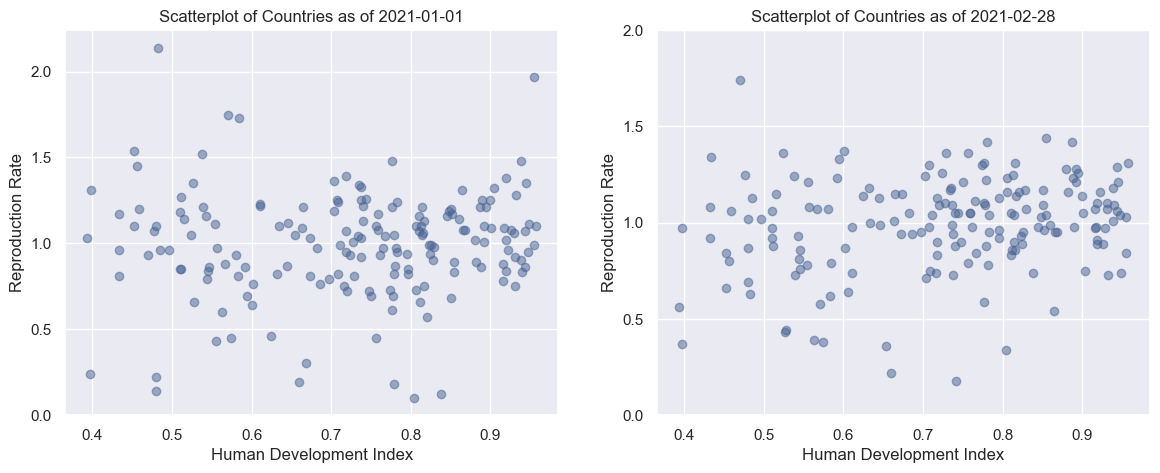

In [48]:
sns.set(style = "darkgrid")
    
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(14,5))

for idx, (ax,this_day) in enumerate(zip([ax1,ax2],[dates_list[0],dates_list[-1]])):
    
    eff_df = df.filter(F.col('human_development_index') != 0.0).filter(F.col('reproduction_rate') != 0.0).filter(F.col('date') == this_day).select(['human_development_index','reproduction_rate','location'])

    pdf = eff_df.select(['human_development_index','reproduction_rate']).toPandas()

    points = ax.scatter(pdf.human_development_index, pdf.reproduction_rate, color=mycol, alpha=0.5)

    ax.set_title(f'Scatterplot of Countries as of {this_day}')
    ax.set_yticks([0.0,0.5,1.0,1.5,2.0])
    ax.set_xlabel('Human Development Index')
    ax.set_ylabel('Reproduction Rate')

plt.show()

matplotlib.rc_file_defaults()

Στην περίπτωση αυτή δε φαίνεται οι υπό μελέτη χώρες να είναι πολύ περισσότερες στην πρώτη περίπτωση σε σχέση με τη δεύτερη. Επιπλέον, ειδικά στη δεύτερη περίπτωση φαίνεται να υπάρχει μια σχετική ομοιομορφία σε ό,τι αφορά το ρυθμό αναπαραγωγής. Πριν κανείς προχωρήσει στις συσταδοποιήσεις, έχει ίσως ενδιαφέρον να απεικονιστεί μέσω ενός .gif (βλ. [Παράρτημα](#appendix)) η χρονική εξέλιξη των άνω διαγραμμάτων διασποράς, ξεκινώντας από το πρώτο (αριστερά) και καταλήγοντας στο δεύτερο (δεξιά). Το .gif παράγεται με το γνωστό έως τώρα τρόπο και φαίνεται ακολούθως:

<center> <img src="https://srigas.me/images/covid_scatterplots.gif" width=420> </center>

Όπως είναι αναμενόμενο, η χρονική εξέλιξη γίνεται αυστηρά κατακόρυφα, αφού σε ένα τόσο μικρό χρονικό διάστημα δεν αναμένεται ο δείκτης ανθρώπινης ανάπτυξης μιας χώρας να μεταβληθεί, εμφανίζοντας μάλιστα (συνολικά) μια μικρή ταλαντωτική συμπεριφορά. Πρόσθετα, ενώ κατά τις πρώτες ημέρες του Ιανουαρίου υπάρχει ικανό πλήθος χωρών με ρυθμό αναπαραγωγής μεγαλύτερο του 1.5, από ένα σημείο και μετά φαίνεται η ταλαντωτική αυτή συμπεριφορά να περιορίζεται στο εύρος [0.5,1.5].

Προχωρώντας τώρα στις συσταδοποιήσεις για την πρώτη και την τελευταία ημέρα του διμήνου, το πλήθος των επιλεγόμενων συστάδων θα τεθεί τώρα ίσο με 3 και για τις δύο περιπτώσεις, αφού δοκιμές που πραγματοποιήθηκαν με διαφορετικούς αριθμούς συστάδων δεν απέδωσαν ενδιαφέροντα ποιοτικά αποτελέσματα. 

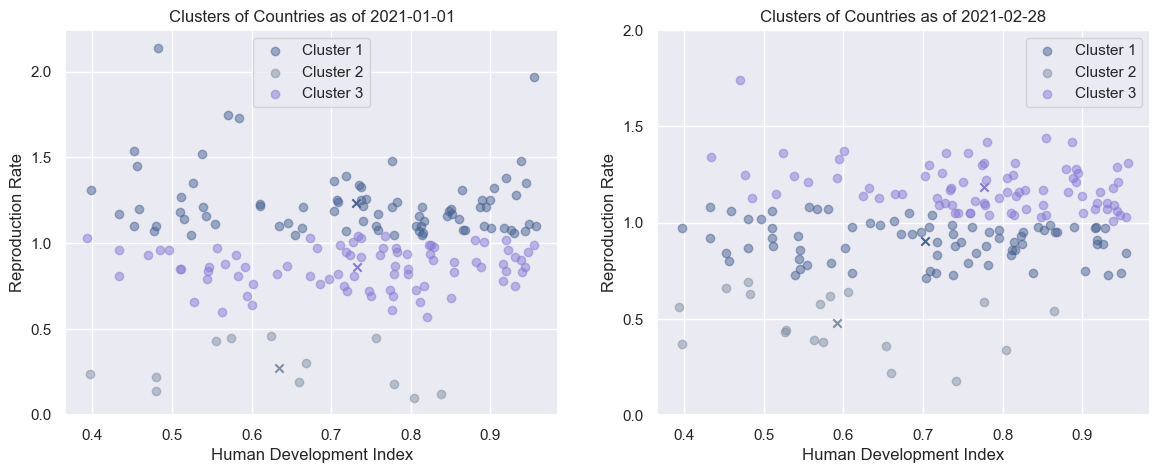

In [49]:
sns.set(style = "darkgrid")

numclusters = [3,3]
colors = [mycol, mycomplcol, othercol1, othercol2, othercol3, othercol4]
    
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(14,5))

for idx, (ax,this_day) in enumerate(zip([ax1,ax2],[dates_list[0],dates_list[-1]])):
    
    eff_df = df.filter(F.col('human_development_index') != 0.0).filter(F.col('reproduction_rate') != 0.0).filter(F.col('date') == this_day).select(['human_development_index','reproduction_rate','location'])

    vectorAssembler = VectorAssembler(inputCols = ['human_development_index','reproduction_rate'], outputCol = "features")
    feat_df = vectorAssembler.transform(eff_df)
    feat_df = feat_df.select(['features','location'])

    kmeans = KMeans().setK(numclusters[idx]).setSeed(1).setFeaturesCol("features").setPredictionCol("cluster")
    model = kmeans.fit(feat_df)
    transformed = model.transform(feat_df)
    centroids = model.clusterCenters()

    transformed = transformed.join(eff_df, 'location')
    
    clusters, centers, images = {}, {}, {}

    for i in range(numclusters[idx]):

        clusters[i] = transformed.filter(F.col('cluster')==i).select(['location','cluster','reproduction_rate',
                                                              'human_development_index']).toPandas().set_index('location')

        images[i] = ax.scatter(clusters[i].human_development_index, clusters[i].reproduction_rate, color=colors[i], alpha=0.5)
        centers[i] = ax.scatter(centroids[i][0], centroids[i][1], color=colors[i], marker='x')

    clusttuple = (images[i] for i in range(numclusters[idx]))
    clustnames = ('Cluster '+str(i+1) for i in range(numclusters[idx]))

    ax.legend(clusttuple, clustnames, loc='best')

    ax.set_title(f'Clusters of Countries as of {this_day}')
    ax.set_yticks([0.0,0.5,1.0,1.5,2.0])
    ax.set_xlabel('Human Development Index')
    ax.set_ylabel('Reproduction Rate')

plt.show()

matplotlib.rc_file_defaults()

Γίνεται εμφανές πως η συσταδοποίηση μέσω k-Means πραγματοποιείται με βάση τις τιμές του κατακόρυφου άξονα, δηλαδή το ρυθμό αναπαραγωγής. Η μία από τις τρεις συστάδες και στις δύο περιπτώσεις περιλαμβάνει χώρες με πολύ μικρό ρυθμό αναπαραγωγής (κάτω του 0.5), ενώ οι υπόλοιπες δύο διαχωρίζουν τις χώρες ως προς το ρυθμό αναπαραγωγής με περιοχή απόφασης κοντά στην τιμή R = 1.0.

Το συγκεκριμένο ζητούμενο χρήζει περαιτέρω διερεύνησης μέσω ενός αλγορίθμου συσταδοποίησης με διαφορετική αρχή λειτουργίας από αυτήν του k-Means (όπως για παράδειγμα density-based μεθόδους, π.χ. DBSCAN). Δυστυχώς, στην PySpark δεν υπάρχει ακόμη πρόβλεψη για τέτοιου είδους αλγορίθμους, επομένως το συγκεκριμένο ζητούμενο θα μπορούσε να μελετηθεί χρησιμοποιώντας τις γνωστές μεθόδους της βιβλιοθήκης `scikit-learn`, με χρήση pandas dataframes.

<a id='appendix'></a>

## Παράρτημα: Πρόσθετος κώδικας για τα ζητούμενα 3.1 - 3.3 και 3.14

Παρατίθεται ακολούθως ο κώδικας βάσει του οποίου εξάγονται οι εικόνες με τα lollipop charts των Ζητουμένων [3.1](#zht3.1) έως και [3.3](#zht3.3), καθώς και με τα διαγράμματα διασποράς του Ζητουμένου [3.14](#zht3.14), οι οποίες ακολούθως μετατρέπονται σε .gif μέσω του Adobe Photoshop.

#### Mortality Rate


```
sns.set(style = "darkgrid")
for this_day in dates_list:
    this_day_top_10 = df_for_mort.filter(F.col('date') == this_day).orderBy("mortality", ascending=False).select(["location","mortality"]).toPandas()

    (markers, stemlines, baseline) = plt.stem(this_day_top_10[0:10]['mortality'])
    plt.setp(markers, color=mycol)
    plt.setp(stemlines, color=mycol)
    plt.setp(baseline, visible=False)
    
    plt.xticks(range(10), this_day_top_10[0:10]['location'], rotation=45)
    plt.title(f'COVID-19 Mortality Rate as of {this_day}', fontsize=14)
    plt.savefig(f'lollipop_chart_cases_{this_day}.png', bbox_inches='tight')
    plt.close()
    
matplotlib.rc_file_defaults()
```

#### Total Cases per Million


```
sns.set(style = "darkgrid")
for this_day in dates_list:
    this_day_top_10 = df.filter(F.col('date') == this_day).orderBy("total_cases_per_million", ascending=False).select(["location","total_cases_per_million"]).toPandas()

    (markers, stemlines, baseline) = plt.stem(this_day_top_10[0:10]['total_cases_per_million'])
    plt.setp(markers, color=mycol)
    plt.setp(stemlines, color=mycol)
    plt.setp(baseline, visible=False)

    plt.xticks(range(10), this_day_top_10[0:10]['location'], rotation=45)
    plt.title(f'Total COVID-19 cases per million as of {this_day}', fontsize=14)
    plt.savefig(f'lollipop_chart_cases_{this_day}.png', bbox_inches='tight')
    plt.close()
    
matplotlib.rc_file_defaults()
```

#### Total Deaths per Million

```
sns.set(style = "darkgrid")
for this_day in dates_list:
    this_day_top_10 = df.filter(F.col('date') == this_day).orderBy("total_deaths_per_million", ascending=False).select(["location","total_deaths_per_million"]).toPandas()

    (markers, stemlines, baseline) = plt.stem(this_day_top_10[0:10]['total_deaths_per_million'])
    plt.setp(markers, color=mycol)
    plt.setp(stemlines, color=mycol)
    plt.setp(baseline, visible=False)

    plt.xticks(range(10), this_day_top_10[0:10]['location'], rotation=45)
    plt.title(f'Total COVID-19 deaths per million as of {this_day}', fontsize=14)
    plt.savefig(f'lollipop_chart_deaths_{this_day}.png', bbox_inches='tight')
    plt.close()
    
matplotlib.rc_file_defaults()
```

#### Human Development Index vs Reproduction Rate

```
sns.set(style = "darkgrid")

for this_day in dates_list:

    fig, ax = plt.subplots(1, 1)
    
    eff_df = df.filter(F.col('human_development_index') != 0.0).filter(F.col('reproduction_rate') != 0.0).filter(F.col('date') == this_day).select(['human_development_index','reproduction_rate','location'])
    pdf = eff_df.select(['human_development_index','reproduction_rate']).toPandas()
    points = ax.scatter(pdf.human_development_index, pdf.reproduction_rate, color=mycol, alpha=0.5)

    ax.set_title(f'Scatterplot of Countries as of {this_day}')
    ax.set_yticks([0.0,0.5,1.0,1.5,2.0])
    ax.set_xlabel('Human Development Index')
    ax.set_ylabel('Reproduction Rate')
    
    plt.savefig(f'hdi_{this_day}.png', bbox_inches='tight')
    plt.close(fig)

matplotlib.rc_file_defaults()
```